# Reward Function Estimation Using LSTM with Attention Mechanism (Overview)

This file implements the **sequential behavioral modeling pipeline**, which captures how user engagement evolves over time as behavioral histories accumulate. Its role is to learn dynamic patterns in user–ad interactions that cannot be represented by static or contextual features alone.

At a high level, the file:
- Constructs **user-level impression sequences**, ordered chronologically, to model temporal dependence in engagement.
- Transforms impression histories into fixed-length or padded sequences suitable for sequence models.
- Trains a **recurrent neural network (LSTM)** to predict click probabilities conditional on past behavior, capturing learning, habit formation, and persistence in user preferences.
- Separates behavioral signals from contextual and geographic information to enable clean comparisons across information regimes.
- Produces **behavioral counterfactual predictions** that are later used for policy evaluation and IPS-based value estimation.
- Saves trained sequence models and out-of-sample predictions for downstream analysis, including residualized spatial tests and complementarity assessments.

In [1]:
import pandas as pd

file_path = 'dataset_LSTM4.csv'
df = pd.read_csv(file_path).copy()

unique_values = df.nunique()

print("Number of unique values in each column:")
print(unique_values)

print(f"Data type of TIME column: {df['TIME'].dtype}")

print("\nDataset info:")
print(df.info())

/tmp/ipykernel_2875838/3324023163.py:5: DtypeWarning: Columns (26,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path).copy()


Number of unique values in each column:
IP_ADDRESS                       1227584
MEDIA_PACKAGE_NAME                  9515
DEVICE_ID                         952155
ANDROID_ID                        439344
MODEL                               4620
BRAND_ID                               7
DATA                                   2
OPERATOR_ID                            3
ISP_ID                                 8
LATITUDE                          250316
LONGITUDE                         280751
CITY                                6306
COUNTRY                              155
PROVINCE                             828
CURRENT_AD_ID                         10
PRICE                                435
CLICK                                  2
FRAUD_CODE                             7
ANDROID_ID_COUNT                       4
YEAR                                   1
MONTH                                  1
DAY                                   12
HOUR                                  24
MINUTE           

## User-Level Train–Test Split and Preprocessing

This step performs the train–test split and applies feature preprocessing in a consistent manner.

Impressions are first sorted by user and time, and a unique identifier is assigned to each record. User-level statistics, including click rate and exposure count, are computed. Users with at least two exposures are split into training and test sets using stratification based on binned click rates to preserve engagement distribution across splits. Users with only one exposure are assigned to the training set.

For consistent transformations, training and test data are temporarily combined. Categorical features are label-encoded, and numerical features are scaled using min–max normalization. A check is performed to ensure no unintended missing values remain. The fitted scaler and encoders are saved.

The data are then separated back into training and test sets and saved as preprocessed datasets for subsequent modeling.


In [2]:
import pandas as pd
import numpy as np
import gc
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
import pickle

data = pd.read_csv("dataset_LSTM4.csv").copy()
print("\nClass distribution (CLICK):")
print(data['CLICK'].value_counts())

if 'ANDROID_ID' not in data.columns or 'TIME' not in data.columns:
    raise ValueError("The dataset must contain 'ANDROID_ID' and 'TIME' columns.")

data = data.sort_values(['ANDROID_ID', 'TIME']).reset_index(drop=True)
data['Unique_ID'] = data.index + 1

print("\nSample records with Unique_ID:")
print(data[['ANDROID_ID', 'TIME', 'Unique_ID']].head())

user_stats = data.groupby('ANDROID_ID', as_index=False).agg(
    CLICK_RATE=('CLICK', 'mean'),
    EXPOSURE_COUNT=('CLICK', 'size')
)

eligible_users = user_stats[user_stats['EXPOSURE_COUNT'] >= 2]
single_exposure_users = user_stats[user_stats['EXPOSURE_COUNT'] < 2]

eligible_users['CLICK_RATE_BIN'] = pd.cut(
    eligible_users['CLICK_RATE'],
    bins=[-0.01, 0.001, 0.01, 0.1, 1.0],
    labels=["Very Low", "Low", "Medium", "High"]
)

train_users, test_users = train_test_split(
    eligible_users['ANDROID_ID'],
    test_size=0.4,
    random_state=42,
    stratify=eligible_users['CLICK_RATE_BIN']
)

train_users_set = set(train_users)
test_users_set = set(test_users)
train_users_set.update(single_exposure_users['ANDROID_ID'])

train_data = data[data['ANDROID_ID'].isin(train_users_set)].copy()
test_data = data[data['ANDROID_ID'].isin(test_users_set)].copy()

del data, user_stats, eligible_users, single_exposure_users
gc.collect()

data_combined = pd.concat([train_data, test_data], axis=0)
data_combined.ffill(inplace=True)

def check_nan_in_combined(data_combined):
    nan_columns = data_combined.columns[data_combined.isnull().any()].tolist()
    if nan_columns:
        print("Columns with NaN values after fillna(0) for time features:")
        for col in nan_columns:
            nan_count = data_combined[col].isnull().sum()
            print(f"Column '{col}' has {nan_count} NaN values.")
    else:
        print("No NaN values detected in any column of data_combined!")

check_nan_in_combined(data_combined)

categorical_features = [
    'MEDIA_PACKAGE_NAME_EMBEDDING', 'MODEL_EMBEDDING',
    'BRAND_ID_EMBEDDING', 'OPERATOR_ID_EMBEDDING',
    'ISP_ID_EMBEDDING', 'CURRENT_AD_ID'
]

label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    data_combined[col] = le.fit_transform(data_combined[col].astype(str))
    label_encoders[col] = le

numerical_features = [
    'HOUR_SIN', 'HOUR_COS', 'MINUTE_SIN', 'MINUTE_COS',
    'AD_FREQUENCY', 'AD_CTR', 'AD_CTR_Overall',
    'EC', 'CH', 'SCTR', 'TSE', 'TSA', 'TCE', 'TCA', 'CTR_i_Ad',
    'Usage_App', 'Effect_App', 'Preference_App', 'Influence_App',
    'Overall_Usage_App', 'Overall_Effect_App'
]

non_numeric_columns = data_combined[numerical_features].select_dtypes(exclude=[np.number]).columns.tolist()
if non_numeric_columns:
    print(f"Warning: Non-numeric columns detected: {non_numeric_columns}")
    numerical_features = [col for col in numerical_features if col not in non_numeric_columns]

scaler = MinMaxScaler()
data_combined[numerical_features] = scaler.fit_transform(data_combined[numerical_features])

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

train_data = data_combined[data_combined['ANDROID_ID'].isin(train_users_set)].copy()
test_data = data_combined[data_combined['ANDROID_ID'].isin(test_users_set)].copy()

del data_combined
gc.collect()

train_data.to_csv('preprocessed_train_data.csv', index=False)
test_data.to_csv('preprocessed_test_data.csv', index=False)
print("Full preprocessed train and test datasets saved.")

/tmp/ipykernel_2875838/3224240507.py:11: DtypeWarning: Columns (26,28) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("dataset_LSTM4.csv").copy()  # Original dataset with all columns



Class distribution (CLICK):
CLICK
0    10379560
1      157619
Name: count, dtype: int64

Sample records with Unique_ID:
   ANDROID_ID     TIME  Unique_ID
0           1  1754345          1
1           1  1754346          2
2           1  1754346          3
3           1  1754346          4
4           1  1754392          5


/tmp/ipykernel_2875838/3224240507.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eligible_users['CLICK_RATE_BIN'] = pd.cut(


Columns with NaN values after fillna(0) for time features:
Column 'ISP_ID' has 60 NaN values.
Column 'FRAUD_CODE' has 1 NaN values.
Full preprocessed train and test datasets saved.


In [8]:
import pandas as pd

train_data = pd.read_csv('preprocessed_train_data.csv')
test_data  = pd.read_csv('preprocessed_test_data.csv')

print(f"Train records: {len(train_data)}")
print(f"Test records:  {len(test_data)}")

print(f"Unique Android_ID in Train: {train_data['ANDROID_ID'].nunique()}")
print(f"Unique Android_ID in Test:  {test_data['ANDROID_ID'].nunique()}")

def share(df):
    return (df["CURRENT_AD_ID"].value_counts(normalize=True)
              .rename("share").sort_index())

ad_share = pd.concat({"train": share(train_data),
                      "test" : share(test_data)}, axis=1).fillna(0)
print("\nAd shares head:\n", ad_share)

/tmp/ipykernel_263128/1113317056.py:5: DtypeWarning: Columns (26,28) have mixed types. Specify dtype option on import or set low_memory=False.
  test_data  = pd.read_csv('preprocessed_test_data.csv')


Train records: 6356413
Test records:  4180766
Unique Android_ID in Train: 297749
Unique Android_ID in Test:  141595

Ad shares head:
                   train      test
CURRENT_AD_ID                    
0              0.055223  0.056366
1              0.117319  0.116961
2              0.113417  0.112720
3              0.135010  0.137379
4              0.084590  0.085222
5              0.126608  0.126198
6              0.222984  0.219605
7              0.050718  0.050533
8              0.063654  0.064845
9              0.030477  0.030170


In [13]:
import pandas as pd

train_data = pd.read_csv('preprocessed_train_data.csv')
test_data  = pd.read_csv('preprocessed_test_data.csv')

print(f"Train records: {len(train_data)}")
print(f"Test records:  {len(test_data)}")

print(f"Unique Android_ID in Train: {train_data['ANDROID_ID'].nunique()}")
print(f"Unique Android_ID in Test:  {test_data['ANDROID_ID'].nunique()}")

def share(df):
    return (df["CURRENT_AD_ID"]
            .value_counts(normalize=True)
            .rename("share")
            .sort_index())

ad_share = pd.concat({
    "train_share": share(train_data),
    "test_share" : share(test_data)
}, axis=1).fillna(0)
print("\nAd share head:\n", ad_share)

def ctr(df):
    return (df.groupby("CURRENT_AD_ID")["CLICK"]
            .mean()
            .rename("ctr")
            .sort_index())

ad_ctr = pd.concat({
    "train_ctr": ctr(train_data),
    "test_ctr" : ctr(test_data)
}, axis=1).fillna(0)
print("\nAd CTR head:\n", ad_ctr)

ad_metrics = pd.concat([ad_share, ad_ctr], axis=1)
print("\nCombined ad metrics head:\n", ad_metrics)

/tmp/ipykernel_263128/3953706396.py:5: DtypeWarning: Columns (26,28) have mixed types. Specify dtype option on import or set low_memory=False.
  test_data  = pd.read_csv('preprocessed_test_data.csv')


Train records: 6356413
Test records:  4180766
Unique Android_ID in Train: 297749
Unique Android_ID in Test:  141595

Ad share head:
                train_share  test_share
CURRENT_AD_ID                         
0                 0.055223    0.056366
1                 0.117319    0.116961
2                 0.113417    0.112720
3                 0.135010    0.137379
4                 0.084590    0.085222
5                 0.126608    0.126198
6                 0.222984    0.219605
7                 0.050718    0.050533
8                 0.063654    0.064845
9                 0.030477    0.030170

Ad CTR head:
                train_ctr  test_ctr
CURRENT_AD_ID                     
0               0.014056  0.013350
1               0.015559  0.014851
2               0.013977  0.013704
3               0.025938  0.025105
4               0.008304  0.007909
5               0.016884  0.016137
6               0.010675  0.010534
7               0.014526  0.013959
8               0.017758  0.016507

/tmp/ipykernel_263128/1316694156.py:7: DtypeWarning: Columns (26,28) have mixed types. Specify dtype option on import or set low_memory=False.
  test_data  = pd.read_csv('preprocessed_test_data.csv')


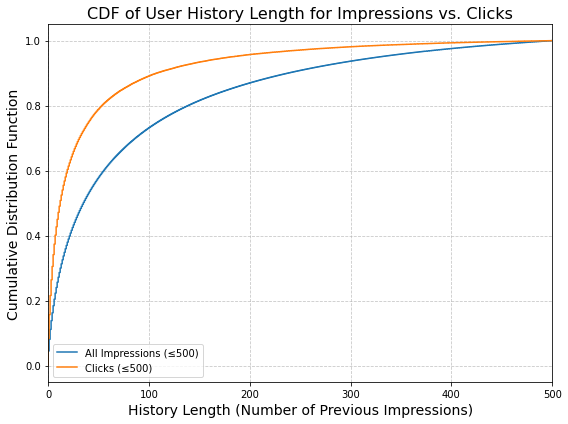


Ad shares head:
 CURRENT_AD_ID
0    0.055677
1    0.117177
2    0.113141
3    0.135950
4    0.084841
5    0.126445
6    0.221644
7    0.050645
8    0.064126
9    0.030355
Name: share, dtype: float64


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

train_data = pd.read_csv('preprocessed_train_data.csv')
test_data  = pd.read_csv('preprocessed_test_data.csv')

df = pd.concat([train_data, test_data], ignore_index=True)

df['history_length'] = df.groupby('ANDROID_ID').cumcount()

all_history  = df['history_length']
click_history = df.loc[df['CLICK'] == 1, 'history_length']

max_hist = 500
all_hist_lim   = all_history[all_history  <= max_hist]
click_hist_lim = click_history[click_history <= max_hist]

def plot_cdf(data, label):
    sorted_data = np.sort(data)
    cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    plt.plot(sorted_data, cdf, label=label)

plt.figure(figsize=(8, 6))
plot_cdf(all_hist_lim,   'All Impressions (≤500)')
plot_cdf(click_hist_lim, 'Clicks (≤500)')
plt.xlabel('History Length (Number of Previous Impressions)', fontsize= 14)
plt.ylabel('Cumulative Distribution Function', fontsize= 14)
plt.title('CDF of User History Length for Impressions vs. Clicks', fontsize= 16)
plt.xlim(0, max_hist)
plt.legend()
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


def share(df):
    return (df["CURRENT_AD_ID"].value_counts(normalize=True)
              .rename("share").sort_index())


print("\nAd shares head:\n", share(df))

In [4]:
import pandas as pd

file_path = 'preprocessed_test_data.csv'
df = pd.read_csv(file_path).copy()

unique_values = df.nunique()

print("Number of unique values in each column:")
print(unique_values)

print(f"Data type of TIME column: {df['TIME'].dtype}")

print("\nDataset info:")
print(df.info())

df = df.sort_values(by=['ANDROID_ID', 'TIME']).reset_index(drop=True)

pd.set_option('display.max_rows', 200)

dff = df.head(2000)

pd.reset_option('display.max_rows')
dff

output_file = "TEST5.csv"
dff.to_csv(output_file, index=False)

/tmp/ipykernel_2875838/685360985.py:5: DtypeWarning: Columns (26,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path).copy()


Number of unique values in each column:
IP_ADDRESS                       528896
MEDIA_PACKAGE_NAME                 8561
DEVICE_ID                        346578
ANDROID_ID                       141595
MODEL                              2995
BRAND_ID                              7
DATA                                  2
OPERATOR_ID                           3
ISP_ID                                8
LATITUDE                         101960
LONGITUDE                        118103
CITY                               3942
COUNTRY                             125
PROVINCE                            553
CURRENT_AD_ID                        10
PRICE                               428
CLICK                                 2
FRAUD_CODE                            7
ANDROID_ID_COUNT                      3
YEAR                                  1
MONTH                                 1
DAY                                  12
HOUR                                 24
MINUTE                               60


### Random User Validation
As a final check, we validate the preprocessing pipeline on a randomly selected user. For a given user ID, we reconstruct the padded sequence, including numerical features, embedding features, targets, masks, timestamps, and unique identifiers. The resulting sequence is exported for manual inspection to verify that all features follow the intended temporal and logical structure, and that padding and masking behave as expected.


In [1]:
import pandas as pd
import numpy as np
import os

test_data = pd.read_csv("preprocessed_test_data.csv").copy()
test_data = test_data[test_data['ANDROID_ID'] == 1369]
if test_data.empty:
    raise ValueError("ANDROID_ID 1369 not found in the dataset.")

test_data.sort_values(['ANDROID_ID', 'TIME'], inplace=True)
test_data['SEQ_POS'] = test_data.groupby('ANDROID_ID').cumcount()

max_seq_length = 150

embedding_features = [
    'MEDIA_PACKAGE_NAME_EMBEDDING', 'MODEL_EMBEDDING',
    'BRAND_ID_EMBEDDING', 'OPERATOR_ID_EMBEDDING',
    'ISP_ID_EMBEDDING', 'CURRENT_AD_ID'
]
numerical_features = [
    'HOUR_SIN', 'HOUR_COS', 'MINUTE_SIN', 'MINUTE_COS',
    'AD_FREQUENCY', 'AD_CTR', 'AD_CTR_Overall',
    'EC', 'CH', 'SCTR', 'TSE', 'TSA', 'TCE', 'TCA', 'CTR_i_Ad',
    'Usage_App', 'Effect_App', 'Preference_App', 'Influence_App',
    'Overall_Usage_App', 'Overall_Effect_App'
]



def prepare_user_data(data, max_seq_length, numerical_features, embedding_features):
    data = data.iloc[-max_seq_length:]
    seq_len = len(data)
    padding_needed = max_seq_length - seq_len

    X_numerical = data[numerical_features].values
    if padding_needed > 0:
        X_numerical = np.pad(X_numerical, ((padding_needed, 0), (0, 0)), mode='constant', constant_values=0.0)

    X_embedding = {}
    for col in embedding_features:
        if col in data.columns:
            X_emb = data[col].values
            if padding_needed > 0:
                X_emb = np.pad(X_emb, (padding_needed, 0), mode='constant', constant_values=0)
            X_embedding[col] = X_emb
        else:
            raise ValueError(f"Embedding column {col} not found in the dataset.")

    y = data['CLICK'].values.astype(float)
    if padding_needed > 0:
        y = np.pad(y, (padding_needed, 0), mode='constant', constant_values=-1.0)
    mask = (y != -1.0).astype(float)
    y = np.where(y == -1.0, 0.0, y)

    time_seq = data['TIME'].values
    if padding_needed > 0:
        time_seq = np.pad(time_seq, (padding_needed, 0), mode='constant', constant_values=0)

    unique_id_seq = data['Unique_ID'].values
    if padding_needed > 0:
        unique_id_seq = np.pad(unique_id_seq, (padding_needed, 0), mode='constant', constant_values=0)

    return X_numerical, X_embedding, y, mask, time_seq, unique_id_seq

X_numerical, X_embedding, y, mask, times, unique_ids = prepare_user_data(
    test_data, max_seq_length, numerical_features, embedding_features
)

debug_data = pd.DataFrame(X_numerical, columns=numerical_features)
debug_data['TARGET'] = y
debug_data['MASK'] = mask
debug_data['TIME'] = times
debug_data['Unique_ID'] = unique_ids

for col in embedding_features:
    debug_data[col] = X_embedding[col]

output_dir = "output"
os.makedirs(output_dir, exist_ok=True)
debug_file_path = os.path.join(output_dir, f"user_1369_debug.csv")
debug_data.to_csv(debug_file_path, index=False)
print("Full preprocessed train and test datasets saved.")

Full preprocessed train and test datasets saved.


## Behavioral Sequence Tensor Construction

This step prepares sequence tensors for the **behavioral model only**, excluding geographic features. The inputs consist of behavioral, temporal, and ad-related features that evolve over user history.

Impressions are sorted chronologically within each user. For each user, the most recent `max_seq_length` observations are retained. Sequences shorter than this length are **right-padded** with zeros to obtain a fixed-length tensor. Numerical features are stored as floating-point arrays, while categorical features are stored as integer arrays for embedding layers.

Targets (`CLICK`) are padded using a sentinel value and a corresponding **mask** is created to indicate valid (non-padded) positions. During training, this mask ensures that padded timesteps do not contribute to the loss, preventing leakage from artificial padding values.

Class weights are computed using valid training targets to address click imbalance.

The final output includes numerical tensors, embedding tensors, target sequences, masks, and metadata for both train and test sets, all saved for downstream LSTM training of the behavioral model.


In [ ]:
import pandas as pd
import numpy as np
import pickle, gc, os
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder

train_data = pd.read_csv("preprocessed_train_data.csv").copy()
test_data  = pd.read_csv("preprocessed_test_data.csv").copy()

label_encoders = {}

for col in geo_cols:
    le = LabelEncoder()
    le.fit(pd.concat([train_data[col], test_data[col]], axis=0).astype(str))
    train_data[f"{col}_EMB"] = le.transform(train_data[col].astype(str))
    test_data[f"{col}_EMB"]  = le.transform(test_data[col].astype(str))
    label_encoders[col] = le

train_data.sort_values(['ANDROID_ID', 'TIME'], inplace=True)
test_data.sort_values(['ANDROID_ID', 'TIME'], inplace=True)

train_data['SEQ_POS'] = train_data.groupby('ANDROID_ID').cumcount()
test_data['SEQ_POS']  = test_data.groupby('ANDROID_ID').cumcount()

max_seq_length = 150

embedding_features = [
    'MEDIA_PACKAGE_NAME_EMBEDDING', 'MODEL_EMBEDDING',
    'BRAND_ID_EMBEDDING', 'OPERATOR_ID_EMBEDDING',
    'ISP_ID_EMBEDDING', 'CURRENT_AD_ID',
]

numerical_features = [
    'HOUR_SIN', 'HOUR_COS', 'MINUTE_SIN', 'MINUTE_COS',
    'AD_FREQUENCY', 'AD_CTR', 'AD_CTR_Overall',
    'EC', 'CH', 'SCTR', 'TSE', 'TSA', 'TCE', 'TCA', 'CTR_i_Ad',
    'Usage_App', 'Effect_App', 'Preference_App', 'Influence_App',
    'Overall_Usage_App',
]

def prepare_data(data, maxlen, num_feats, emb_feats):
    data = data.groupby('ANDROID_ID', group_keys=False).apply(lambda x: x.iloc[-maxlen:])
    data.reset_index(drop=True, inplace=True)
    data['SEQ_POS'] = data.groupby('ANDROID_ID').cumcount()
    data.set_index(['ANDROID_ID', 'SEQ_POS'], inplace=True)

    user_ids = data.index.get_level_values(0).unique()
    X_num_all, y_all, mask_all, time_all, uid_all = [], [], [], [], []
    X_emb_dict = {c: [] for c in emb_feats}

    for uid in user_ids:
        seq = data.loc[uid]
        pad = maxlen - len(seq)

        X_num = seq[num_feats].values.astype(np.float64)
        if pad:
            X_num = np.pad(X_num, ((0, pad), (0, 0)))
        X_num_all.append(X_num)

        for col in emb_feats:
            X_e = seq[col].values.astype(np.int64)
            if pad:
                X_e = np.pad(X_e, (0, pad))
            X_emb_dict[col].append(X_e)

        y = seq['CLICK'].values.astype(np.float64)
        if pad:
            y = np.pad(y, (0, pad), constant_values=-1)
        mask = (y != -1).astype(np.float64)
        y[y == -1] = 0
        y_all.append(y)
        mask_all.append(mask)

        t = seq['TIME'].values
        u = seq['Unique_ID'].values
        if pad:
            t = np.pad(t, (0, pad))
            u = np.pad(u, (0, pad))
        time_all.append(t)
        uid_all.append(u)

    return (
        np.array(X_num_all, dtype=np.float64),
        {k: np.array(v, dtype=np.int64) for k, v in X_emb_dict.items()},
        np.array(y_all, dtype=np.float64),
        np.array(mask_all, dtype=np.float64),
        user_ids.tolist(),
        time_all,
        uid_all
    )

X_train_num, X_train_emb, y_train, train_mask, train_ids, train_times, train_uids = prepare_data(
    train_data, max_seq_length, numerical_features, embedding_features
)

X_test_num, X_test_emb, y_test, test_mask, test_ids, test_times, test_uids = prepare_data(
    test_data, max_seq_length, numerical_features, embedding_features
)

valid_clicks = y_train[train_mask == 1]
cw = class_weight.compute_class_weight('balanced', classes=np.unique(valid_clicks), y=valid_clicks)
class_weight_dict = {i: w for i, w in enumerate(cw)}

out = {
    'X_train_numerical': X_train_num,
    'X_train_embedding': X_train_emb,
    'y_train': y_train,
    'train_mask': train_mask,
    'X_test_numerical': X_test_num,
    'X_test_embedding': X_test_emb,
    'y_test': y_test,
    'test_mask': test_mask,
    'class_weight_dict': class_weight_dict,
    'max_seq_length': max_seq_length,
    'numerical_features': numerical_features,
    'embedding_features': embedding_features,
    'train_user_ids': train_ids,
    'train_times': train_times,
    'train_unique_ids': train_uids,
    'test_user_ids': test_ids,
    'test_times': test_times,
    'test_unique_ids': test_uids,
}

with open('processed_data_pytorch.pkl', 'wb') as f:
    pickle.dump(out, f)

with open('label_encoders0.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)

with open('params0.pkl', 'wb') as f:
    pickle.dump({
        'max_seq_length': max_seq_length,
        'numerical_features': numerical_features,
        'embedding_features': embedding_features
    }, f)


### LSTM Data Validation For Behavioral Model

We validate the LSTM data construction by selecting random users from the processed test set and reconstructing their full padded sequences. For each user, we inspect numerical features, embedding features, targets, masks, timestamps, and unique identifiers to ensure that sequence truncation, right-padding, and masking follow the intended temporal logic. This step confirms that the model inputs are correctly aligned and that padded positions are properly identified.


In [2]:
import numpy as np
import pandas as pd
import pickle
import os

with open("processed_data_pytorch.pkl", "rb") as f:
    processed_data = pickle.load(f)

processed_data_keys = list(processed_data.keys())
print(processed_data_keys)

X_test_numerical = processed_data["X_test_numerical"]
X_test_embedding = processed_data["X_test_embedding"]
y_test = processed_data["y_test"]
test_mask = processed_data["test_mask"]
test_user_ids = processed_data["test_user_ids"]
test_times = processed_data["test_times"]
test_unique_ids = processed_data["test_unique_ids"]

numerical_features = processed_data["numerical_features"]
embedding_features = processed_data["embedding_features"]

print("Numerical Features Columns:")
print(numerical_features)

print("\nEmbedding Features Columns:")
print(embedding_features)

target_id = 1369

if target_id not in test_user_ids:
    raise ValueError(f"ANDROID_ID {target_id} not found in the processed test data.")

target_index = test_user_ids.index(target_id)

retrieved_numerical = np.array(X_test_numerical)[target_index]

retrieved_embedding = {
    feature: np.array(X_test_embedding[feature])[target_index] for feature in embedding_features
}

retrieved_y = np.array(y_test)[target_index]
retrieved_mask = np.array(test_mask)[target_index]
retrieved_times = np.array(test_times)[target_index]
retrieved_unique_ids = np.array(test_unique_ids)[target_index]

retrieved_data = pd.DataFrame(retrieved_numerical, columns=numerical_features)
retrieved_data["TARGET"] = retrieved_y
retrieved_data["MASK"] = retrieved_mask
retrieved_data["TIME"] = retrieved_times
retrieved_data["Unique_ID"] = retrieved_unique_ids

for feature in embedding_features:
    retrieved_data[feature] = retrieved_embedding[feature]

valid_data = retrieved_data[retrieved_data["MASK"] == 1]

output_dir = "output"
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, f"retrieved_user_{target_id}_test.csv")
retrieved_data.to_csv(output_file, index=False)

print(f"Retrieved test data for ANDROID_ID {target_id} has been saved to {output_file}")
print("\nSample retrieved data (valid entries):")
print(retrieved_data.head(150))


['X_train_numerical', 'X_train_embedding', 'y_train', 'train_mask', 'X_test_numerical', 'X_test_embedding', 'y_test', 'test_mask', 'class_weight_dict', 'max_seq_length', 'numerical_features', 'embedding_features', 'train_user_ids', 'train_times', 'train_unique_ids', 'test_user_ids', 'test_times', 'test_unique_ids']
Numerical Features Columns:
['HOUR_SIN', 'HOUR_COS', 'MINUTE_SIN', 'MINUTE_COS', 'AD_FREQUENCY', 'AD_CTR', 'AD_CTR_Overall', 'EC', 'CH', 'SCTR', 'TSE', 'TSA', 'TCE', 'TCA', 'CTR_i_Ad', 'Usage_App', 'Effect_App', 'Preference_App', 'Influence_App', 'Overall_Usage_App']

Embedding Features Columns:
['MEDIA_PACKAGE_NAME_EMBEDDING', 'MODEL_EMBEDDING', 'BRAND_ID_EMBEDDING', 'OPERATOR_ID_EMBEDDING', 'ISP_ID_EMBEDDING', 'CURRENT_AD_ID']
Retrieved test data for ANDROID_ID 1369 has been saved to output/retrieved_user_1369_test.csv

Sample retrieved data (valid entries):
     HOUR_SIN  HOUR_COS  MINUTE_SIN  MINUTE_COS  AD_FREQUENCY  AD_CTR  \
0    0.982963   0.37059    0.066987    0.25

In [3]:
import pickle
with open('processed_data_pytorch.pkl', 'rb') as f:
    processed_data = pickle.load(f)

processed_data['X_test_embedding']  
processed_data['X_test_embedding'] 

{'MEDIA_PACKAGE_NAME_EMBEDDING': array([[46, 46, 46, ...,  0,  0,  0],
        [12, 12, 46, ...,  0,  0,  0],
        [46, 46,  0, ...,  0,  0,  0],
        ...,
        [46, 46, 46, ...,  0,  0,  0],
        [46, 46, 46, ...,  0,  0,  0],
        [ 3,  3,  3, ...,  0,  0,  0]]),
 'MODEL_EMBEDDING': array([[27, 27, 27, ...,  0,  0,  0],
        [46, 46, 46, ...,  0,  0,  0],
        [ 2,  2,  0, ...,  0,  0,  0],
        ...,
        [46, 46, 46, ...,  0,  0,  0],
        [11, 11, 11, ...,  0,  0,  0],
        [46, 46, 46, ...,  0,  0,  0]]),
 'BRAND_ID_EMBEDDING': array([[1, 1, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [1, 1, 0, ..., 0, 0, 0],
        ...,
        [2, 2, 2, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 'OPERATOR_ID_EMBEDDING': array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 0, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [2, 2

### Full Model Sequence Tensor Construction (Behavioral + Geographical)

This step prepares sequence tensors for the **full model**, which includes both behavioral features and geographic information. The inputs combine dynamic behavioral variables, ad-related metrics, temporal signals, and encoded geographic features (e.g., city, province, country).

Impressions are sorted chronologically within each user. For each user, the most recent `max_seq_length` observations are retained. Sequences shorter than this length are **right-padded** with zeros to produce fixed-length tensors suitable for batch training. Numerical features are stored as floating-point arrays, and categorical features—including geographic embeddings—are stored as integer arrays for embedding layers.

Targets (`CLICK`) are padded using a sentinel value, and a corresponding **mask** is constructed to identify valid timesteps. During training, this mask ensures that padded positions do not contribute to the loss, so only real historical observations influence parameter updates.

Class weights are computed from valid training targets to account for class imbalance in click prediction.

The resulting artifacts include numerical tensors, embedding tensors (behavioral and geographic), target sequences, masks, and metadata for both training and test sets. These are serialized and saved for downstream LSTM training of the full model.


In [ ]:
import pandas as pd
import numpy as np
import pickle, gc, os
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder

train_data = pd.read_csv("preprocessed_train_data.csv").copy()
test_data  = pd.read_csv("preprocessed_test_data.csv").copy()

label_encoders = {}

for col in geo_cols:
    le = LabelEncoder()
    le.fit(pd.concat([train_data[col], test_data[col]], axis=0).astype(str))
    train_data[f"{col}_EMB"] = le.transform(train_data[col].astype(str))
    test_data[f"{col}_EMB"]  = le.transform(test_data[col].astype(str))
    label_encoders[col] = le

train_data.sort_values(['ANDROID_ID', 'TIME'], inplace=True)
test_data.sort_values(['ANDROID_ID', 'TIME'], inplace=True)

train_data['SEQ_POS'] = train_data.groupby('ANDROID_ID').cumcount()
test_data['SEQ_POS']  = test_data.groupby('ANDROID_ID').cumcount()

max_seq_length = 150

embedding_features = [
    'MEDIA_PACKAGE_NAME_EMBEDDING', 'MODEL_EMBEDDING',
    'BRAND_ID_EMBEDDING', 'OPERATOR_ID_EMBEDDING',
    'ISP_ID_EMBEDDING', 'CURRENT_AD_ID',
    'CITY', 'PROVINCE'  # geo categorical
]

numerical_features = [
    'HOUR_SIN', 'HOUR_COS', 'MINUTE_SIN', 'MINUTE_COS',
    'AD_FREQUENCY', 'AD_CTR', 'AD_CTR_Overall',
    'EC', 'CH', 'SCTR', 'TSE', 'TSA', 'TCE', 'TCA', 'CTR_i_Ad',
    'Usage_App', 'Effect_App', 'Preference_App', 'Influence_App',
    'Overall_Usage_App',
    'LATITUDE', 'LONGITUDE' # geo numeric
]

def prepare_data(data, maxlen, num_feats, emb_feats):
    data = data.groupby('ANDROID_ID', group_keys=False).apply(lambda x: x.iloc[-maxlen:])
    data.reset_index(drop=True, inplace=True)
    data['SEQ_POS'] = data.groupby('ANDROID_ID').cumcount()
    data.set_index(['ANDROID_ID', 'SEQ_POS'], inplace=True)

    user_ids = data.index.get_level_values(0).unique()
    X_num_all, y_all, mask_all, time_all, uid_all = [], [], [], [], []
    X_emb_dict = {c: [] for c in emb_feats}

    for uid in user_ids:
        seq = data.loc[uid]
        pad = maxlen - len(seq)

        X_num = seq[num_feats].values.astype(np.float64)
        if pad:
            X_num = np.pad(X_num, ((0, pad), (0, 0)))
        X_num_all.append(X_num)

        for col in emb_feats:
            X_e = seq[col].values.astype(np.int64)
            if pad:
                X_e = np.pad(X_e, (0, pad))
            X_emb_dict[col].append(X_e)

        y = seq['CLICK'].values.astype(np.float64)
        if pad:
            y = np.pad(y, (0, pad), constant_values=-1)
        mask = (y != -1).astype(np.float64)
        y[y == -1] = 0
        y_all.append(y)
        mask_all.append(mask)

        t = seq['TIME'].values
        u = seq['Unique_ID'].values
        if pad:
            t = np.pad(t, (0, pad))
            u = np.pad(u, (0, pad))
        time_all.append(t)
        uid_all.append(u)

    return (
        np.array(X_num_all, dtype=np.float64),
        {k: np.array(v, dtype=np.int64) for k, v in X_emb_dict.items()},
        np.array(y_all, dtype=np.float64),
        np.array(mask_all, dtype=np.float64),
        user_ids.tolist(),
        time_all,
        uid_all
    )

X_train_num, X_train_emb, y_train, train_mask, train_ids, train_times, train_uids = prepare_data(
    train_data, max_seq_length, numerical_features, embedding_features
)

X_test_num, X_test_emb, y_test, test_mask, test_ids, test_times, test_uids = prepare_data(
    test_data, max_seq_length, numerical_features, embedding_features
)

valid_clicks = y_train[train_mask == 1]
cw = class_weight.compute_class_weight('balanced', classes=np.unique(valid_clicks), y=valid_clicks)
class_weight_dict = {i: w for i, w in enumerate(cw)}

out = {
    'X_train_numerical': X_train_num,
    'X_train_embedding': X_train_emb,
    'y_train': y_train,
    'train_mask': train_mask,
    'X_test_numerical': X_test_num,
    'X_test_embedding': X_test_emb,
    'y_test': y_test,
    'test_mask': test_mask,
    'class_weight_dict': class_weight_dict,
    'max_seq_length': max_seq_length,
    'numerical_features': numerical_features,
    'embedding_features': embedding_features,
    'train_user_ids': train_ids,
    'train_times': train_times,
    'train_unique_ids': train_uids,
    'test_user_ids': test_ids,
    'test_times': test_times,
    'test_unique_ids': test_uids,
}

with open('processed_data_pytorch2.pkl', 'wb') as f:
    pickle.dump(out, f)

with open('label_encoders2.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)

with open('params2.pkl', 'wb') as f:
    pickle.dump({
        'max_seq_length': max_seq_length,
        'numerical_features': numerical_features,
        'embedding_features': embedding_features
    }, f)


### LSTM Data Validation For Full Model (Behavioral + Geographical)

We validate the LSTM data construction by selecting random users from the processed test set and reconstructing their full padded sequences. For each user, we inspect numerical features, embedding features, targets, masks, timestamps, and unique identifiers to ensure that sequence truncation, right-padding, and masking follow the intended temporal logic. This step confirms that the model inputs are correctly aligned and that padded positions are properly identified.


In [4]:
import numpy as np
import pandas as pd
import pickle
import os

with open("processed_data_pytorch2.pkl", "rb") as f:
    processed_data = pickle.load(f)

processed_data_keys = list(processed_data.keys())
print(processed_data_keys)

X_test_numerical = processed_data["X_test_numerical"]
X_test_embedding = processed_data["X_test_embedding"]
y_test = processed_data["y_test"]
test_mask = processed_data["test_mask"]
test_user_ids = processed_data["test_user_ids"]
test_times = processed_data["test_times"]
test_unique_ids = processed_data["test_unique_ids"]

numerical_features = processed_data["numerical_features"]
embedding_features = processed_data["embedding_features"]

print("Numerical Features Columns:")
print(numerical_features)

print("\nEmbedding Features Columns:")
print(embedding_features)

target_id = 1369

if target_id not in test_user_ids:
    raise ValueError(f"ANDROID_ID {target_id} not found in the processed test data.")

target_index = test_user_ids.index(target_id)

retrieved_numerical = np.array(X_test_numerical)[target_index]

retrieved_embedding = {
    feature: np.array(X_test_embedding[feature])[target_index] for feature in embedding_features
}

retrieved_y = np.array(y_test)[target_index]
retrieved_mask = np.array(test_mask)[target_index]
retrieved_times = np.array(test_times)[target_index]
retrieved_unique_ids = np.array(test_unique_ids)[target_index]

retrieved_data = pd.DataFrame(retrieved_numerical, columns=numerical_features)
retrieved_data["TARGET"] = retrieved_y
retrieved_data["MASK"] = retrieved_mask
retrieved_data["TIME"] = retrieved_times
retrieved_data["Unique_ID"] = retrieved_unique_ids

for feature in embedding_features:
    retrieved_data[feature] = retrieved_embedding[feature]

valid_data = retrieved_data[retrieved_data["MASK"] == 1]

output_dir = "output"
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, f"retrieved_user_{target_id}_test.csv")
retrieved_data.to_csv(output_file, index=False)

print(f"Retrieved test data for ANDROID_ID {target_id} has been saved to {output_file}")
print("\nSample retrieved data (valid entries):")
print(retrieved_data.head(150))


['X_train_numerical', 'X_train_embedding', 'y_train', 'train_mask', 'X_test_numerical', 'X_test_embedding', 'y_test', 'test_mask', 'class_weight_dict', 'max_seq_length', 'numerical_features', 'embedding_features', 'train_user_ids', 'train_times', 'train_unique_ids', 'test_user_ids', 'test_times', 'test_unique_ids']
Numerical Features Columns:
['HOUR_SIN', 'HOUR_COS', 'MINUTE_SIN', 'MINUTE_COS', 'AD_FREQUENCY', 'AD_CTR', 'AD_CTR_Overall', 'EC', 'CH', 'SCTR', 'TSE', 'TSA', 'TCE', 'TCA', 'CTR_i_Ad', 'Usage_App', 'Effect_App', 'Preference_App', 'Influence_App', 'Overall_Usage_App', 'LATITUDE', 'LONGITUDE']

Embedding Features Columns:
['MEDIA_PACKAGE_NAME_EMBEDDING', 'MODEL_EMBEDDING', 'BRAND_ID_EMBEDDING', 'OPERATOR_ID_EMBEDDING', 'ISP_ID_EMBEDDING', 'CURRENT_AD_ID', 'CITY', 'PROVINCE']
Retrieved test data for ANDROID_ID 1369 has been saved to output/retrieved_user_1369_test.csv

Sample retrieved data (valid entries):
     HOUR_SIN  HOUR_COS  MINUTE_SIN  MINUTE_COS  AD_FREQUENCY  AD_CTR  

In [5]:
import pickle
with open('processed_data_pytorch2.pkl', 'rb') as f:
    processed_data = pickle.load(f)

processed_data['X_test_embedding']  
processed_data['X_test_embedding']

{'MEDIA_PACKAGE_NAME_EMBEDDING': array([[46, 46, 46, ...,  0,  0,  0],
        [12, 12, 46, ...,  0,  0,  0],
        [46, 46,  0, ...,  0,  0,  0],
        ...,
        [46, 46, 46, ...,  0,  0,  0],
        [46, 46, 46, ...,  0,  0,  0],
        [ 3,  3,  3, ...,  0,  0,  0]]),
 'MODEL_EMBEDDING': array([[27, 27, 27, ...,  0,  0,  0],
        [46, 46, 46, ...,  0,  0,  0],
        [ 2,  2,  0, ...,  0,  0,  0],
        ...,
        [46, 46, 46, ...,  0,  0,  0],
        [11, 11, 11, ...,  0,  0,  0],
        [46, 46, 46, ...,  0,  0,  0]]),
 'BRAND_ID_EMBEDDING': array([[1, 1, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [1, 1, 0, ..., 0, 0, 0],
        ...,
        [2, 2, 2, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 'OPERATOR_ID_EMBEDDING': array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 0, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [2, 2

# Full LSTM–Attention Sequence Model for Reward Function Estimation (Click Prediction)

This script implements and trains a deep sequential model for user-level click prediction. The model operates at the impression sequence level, producing a click probability for each timestep while respecting temporal order and padding structure.

## Model Architecture

The architecture is designed to model sequential behavioral dynamics while preventing information leakage from future impressions.

At each timestep, the input representation is constructed by concatenating:

1. Numerical behavioral features.
2. Learned embeddings for categorical features.

Each categorical feature is mapped to an embedding space using `nn.Embedding` with `padding_idx=0`, ensuring padded tokens do not introduce learned signal.

The combined feature vector is then enriched with:

- A learned absolute positional embedding, allowing the model to distinguish sequence positions.
- An optional projected time-gap embedding (`log(1 + Δt)`), which encodes temporal spacing between consecutive impressions.

The sequential backbone consists of a multi-layer LSTM. This component captures temporal dependencies in user behavior and produces hidden representations for every timestep.

On top of the LSTM outputs, a **causal multi-head self-attention layer** is applied. Two masking mechanisms are used:

- A **causal mask** (upper triangular) blocks access to future timesteps, ensuring predictions at time \( t \) depend only on information from \( \leq t \).
- A **key padding mask** ignores padded positions introduced during sequence padding.

The attention output is combined with a residual connection and layer normalization.

The final representation passes through a gated projection head:
- A sigmoid gate controls information flow.
- A tanh-transformed body provides nonlinear transformation.
- Dropout regularizes the gated output.

A final linear layer produces one logit per timestep. During training and evaluation, logits are converted to probabilities using the sigmoid function.

## Data Handling and Masking

Sequences are padded to a fixed maximum length. A binary mask identifies valid (non-padded) positions.  

Loss and metrics are computed only on positions where `mask == 1`, ensuring padded timesteps do not affect training or evaluation.

## Training Procedure

The model is trained using:

- **BCEWithLogitsLoss**
- **AdamW optimizer**
- Gradient clipping (max norm = 1.0)
- Learning rate scheduling via `ReduceLROnPlateau` (monitored on validation AUC)

Each epoch computes:

- Loss
- AUC
- Average Precision
- Gini coefficient
- Accuracy, Precision, Recall, and F1 (threshold = 0.5)
- Confusion matrices
- Relative Information Gain (RIG)

Validation predictions are stored with associated `Unique_ID` and `Ad_ID` for downstream analysis.

Model checkpoints and performance plots are saved after every epoch.

### Summary

This implementation combines LSTM-based sequential modeling with causal self-attention and strict masking, ensuring temporally valid click prediction at the impression level while handling padded sequences correctly.


## Train LSTM with Attention for Full Model (Behavioral + Geographical)

In [2]:
import os
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pickle
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score, recall_score, f1_score,
    average_precision_score, confusion_matrix, precision_recall_curve, roc_curve
)
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import random
import pandas as pd
import random
import math

os.makedirs("Models2", exist_ok=True)
os.makedirs("plots2", exist_ok=True)

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

class NASSequenceModel(nn.Module):
    def __init__(self, 
                 numerical_features,
                 categorical_features,
                 embedding_dims,
                 label_encoders,
                 hidden_size=512,
                 lstm_layers=4,
                 attention_heads=4,
                 attention_dropout=0.2,
                 fc_dropout=0.2,
                 max_seq_len=150):
        super().__init__()

        self.numerical_features   = numerical_features
        self.categorical_features = categorical_features

        self.embeddings = nn.ModuleDict({
            col: nn.Embedding(
                len(label_encoders[col].classes_) + 1,
                embedding_dims[col],
                padding_idx=0
            )
            for col in categorical_features
        })
        total_embed_dim = sum(embedding_dims[c] for c in categorical_features)
        input_dim       = total_embed_dim + len(numerical_features)

        self.abs_pos_emb   = nn.Parameter(torch.zeros(1, max_seq_len, input_dim))
        self.time_gap_proj = nn.Linear(1, input_dim)

        self.lstm = nn.LSTM(input_dim, hidden_size,
                            num_layers=lstm_layers, batch_first=True)

        self.layer_norm_pre_attn  = nn.LayerNorm(hidden_size)
        self.multihead_attn = nn.MultiheadAttention(
            hidden_size, attention_heads, attention_dropout, batch_first=True
        )
        self.layer_norm_post_attn = nn.LayerNorm(hidden_size)

        self.gate_proj = nn.Linear(hidden_size, hidden_size)
        self.body_proj = nn.Linear(hidden_size, hidden_size)
        self.fc_out    = nn.Linear(hidden_size, 1)
        self.dropout   = nn.Dropout(fc_dropout)

    def forward(self, X_num, X_cat, mask=None, delta_t=None):
        cat_parts = [self.embeddings[col](X_cat[col]) for col in self.categorical_features]
        x_cat  = torch.cat(cat_parts, dim=-1)
        x      = torch.cat([X_num, x_cat], dim=-1)

        x = x + self.abs_pos_emb[:, :x.size(1), :]

        if delta_t is not None:
            x = x + self.time_gap_proj(torch.log1p(delta_t))

        x, _ = self.lstm(x)

        residual = x
        x = self.layer_norm_pre_attn(x)
        key_padding = None if mask is None else (mask == 0)
        seq_len = x.size(1)
        causal_mask = torch.triu(torch.ones(seq_len, seq_len, device=x.device, dtype=torch.bool),
                                 diagonal=1)
        attn_out, _ = self.multihead_attn(x, x, x,
                                          attn_mask=causal_mask,
                                          key_padding_mask=key_padding)
        x = residual + attn_out
        x = self.layer_norm_post_attn(x)

        gate = torch.sigmoid(self.gate_proj(x))
        body = torch.tanh(self.body_proj(x))
        x = self.dropout(gate * body)
        logits = self.fc_out(x).squeeze(-1)

        return logits

class UserSequenceDataset(Dataset):
    def __init__(self, X_numerical, X_categorical, y, mask, unique_ids):
        self.X_numerical = torch.tensor(X_numerical, dtype=torch.float32)
        self.X_categorical = {col: torch.tensor(values, dtype=torch.long) for col, values in X_categorical.items()}
        self.y = torch.tensor(y, dtype=torch.float32)
        self.mask = torch.tensor(mask, dtype=torch.float32)
        self.unique_ids = unique_ids
        self.num_samples = self.X_numerical.shape[0]

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        X_num = self.X_numerical[idx]
        X_cat = {col: values[idx] for col, values in self.X_categorical.items()}
        y_seq = self.y[idx]
        mask_seq = self.mask[idx]
        unique_id = torch.tensor(self.unique_ids[idx], dtype=torch.long)
        if unique_id.dim() == 2:
            unique_id = unique_id[:, 0]
        return (X_num, X_cat), y_seq, mask_seq, unique_id

with open('processed_data_pytorch2.pkl', 'rb') as f:
    processed_data = pickle.load(f)

X_train_numerical = processed_data['X_train_numerical']
X_train_categorical = processed_data['X_train_embedding']
y_train = processed_data['y_train']
train_mask = processed_data['train_mask']
train_unique_ids = processed_data.get('train_unique_ids', [])
X_test_numerical = processed_data['X_test_numerical']
X_test_categorical = processed_data['X_test_embedding']
y_test = processed_data['y_test']
test_mask = processed_data['test_mask']
test_unique_ids = processed_data.get('test_unique_ids', [])
class_weight_dict = processed_data['class_weight_dict']
max_seq_length = processed_data['max_seq_length']
numerical_features = processed_data['numerical_features']
categorical_features = processed_data['embedding_features']

print("Processed data loaded successfully.")

train_dataset = UserSequenceDataset(X_train_numerical, X_train_categorical, y_train, train_mask, train_unique_ids)
test_dataset = UserSequenceDataset(X_test_numerical, X_test_categorical, y_test, test_mask, test_unique_ids)

num_workers = 20
batch_size = 256

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

class MockLabelEncoder:
    def __init__(self, num_classes):
        self.classes_ = list(range(num_classes))

mock_label_encoders = {col: MockLabelEncoder(num_classes=int(np.max(X_train_categorical[col]) + 1))
                       for col in categorical_features}

embedding_dims = {col: int(min(50, np.ceil((np.max(X_train_categorical[col]) + 1) / 2)))
                  for col in categorical_features}

model = NASSequenceModel(numerical_features, categorical_features, embedding_dims, mock_label_encoders)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.9, patience=20, verbose=True)

y_train_flat = np.array(y_train).flatten()
train_mask_flat = np.array(train_mask).flatten()
y_train_valid = y_train_flat[train_mask_flat == 1]
baseline_ctr = y_train_valid.mean()
baseline_loss = - (baseline_ctr * np.log(baseline_ctr + 1e-9) +
                   (1 - baseline_ctr) * np.log((1 - baseline_ctr) + 1e-9))
baseline_loss = max(baseline_loss, 1e-12)

num_epochs = 50
best_val_auc = 0.0
epochs_list, train_loss_list, val_loss_list = [], [], []
train_auc_list, val_auc_list = [], []
train_ap_list,  val_ap_list  = [], []
train_gini_list, val_gini_list = [], []
train_rig_list,  val_rig_list  = [], []

for epoch in range(num_epochs):
    model.train()
    train_losses, train_y_true, train_y_pred = [], [], []

    for (X_num_batch, X_cat_batch), y_batch, mask_batch, unique_id_batch in tqdm(
            train_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Training'):

        X_num_batch = X_num_batch.to(device)
        X_cat_batch = {col: X_cat_batch[col].to(device) for col in X_cat_batch}
        y_batch     = y_batch.to(device)
        mask_batch  = mask_batch.to(device)

        optimizer.zero_grad()
        logits = model(X_num_batch, X_cat_batch, mask=mask_batch)
        logits_flat    = logits.view(-1)
        y_batch_flat   = y_batch.view(-1)
        mask_flat      = mask_batch.view(-1)
        valid_idx      = mask_flat == 1
        logits_valid   = logits_flat[valid_idx]
        y_valid        = y_batch_flat[valid_idx]

        loss = criterion(logits_valid, y_valid.float())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        train_losses.append(loss.item())
        train_y_true.extend(y_valid.detach().cpu().numpy())
        train_y_pred.extend(torch.sigmoid(logits_valid.detach()).cpu().numpy())

    train_loss = np.mean(train_losses)
    train_auc  = roc_auc_score(train_y_true, train_y_pred)
    train_ap   = average_precision_score(train_y_true, train_y_pred)
    train_gini = 2 * train_auc - 1

    optimal_threshold_train = 0.5

    train_pred_labels = (np.array(train_y_pred) >= 0.5).astype(int)
    train_accuracy    = accuracy_score(train_y_true, train_pred_labels)
    train_precision   = precision_score(train_y_true, train_pred_labels, zero_division=0)
    train_recall      = recall_score(train_y_true, train_pred_labels,  zero_division=0)
    train_f1          = f1_score(train_y_true,   train_pred_labels,  zero_division=0)
    train_cm = confusion_matrix(train_y_true, train_pred_labels)

    model.eval()
    val_losses, y_true_val, y_pred_val, val_predictions = [], [], [], []

    with torch.no_grad():
        for (X_num_batch, X_cat_batch), y_batch, mask_batch, unique_id_batch in tqdm(
                test_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Validation'):

            X_num_batch = X_num_batch.to(device)
            X_cat_batch = {col: X_cat_batch[col].to(device) for col in X_cat_batch}
            y_batch     = y_batch.to(device)
            mask_batch  = mask_batch.to(device)

            actual_ad_ids = X_cat_batch["CURRENT_AD_ID"].view(-1)
            logits = model(X_num_batch, X_cat_batch, mask=mask_batch)

            logits_flat    = logits.view(-1)
            y_batch_flat   = y_batch.view(-1)
            mask_flat      = mask_batch.view(-1)
            unique_id_flat = unique_id_batch.view(-1)

            valid_idx      = mask_flat == 1
            logits_valid   = logits_flat[valid_idx]
            y_valid        = y_batch_flat[valid_idx]
            uid_valid      = unique_id_flat[valid_idx]

            ad_ids_valid = actual_ad_ids[valid_idx].cpu().numpy()
            preds_valid  = torch.sigmoid(logits_valid).cpu().numpy()
            actual_y_val = y_valid.cpu().numpy()

            for uid, pred, actual, ad_id in zip(uid_valid.cpu().numpy(),
                                                preds_valid, actual_y_val, ad_ids_valid):
                val_predictions.append({
                    'Unique_ID': uid,
                    'Predicted_Y': pred,
                    'Actual_Y': actual,
                    'Actual_Ad_ID': ad_id
                })

            loss = criterion(logits_valid, y_valid.float())
            val_losses.append(loss.item())
            y_true_val.extend(actual_y_val)
            y_pred_val.extend(preds_valid)

    val_loss = np.mean(val_losses)
    val_auc  = roc_auc_score(y_true_val, y_pred_val)
    val_ap   = average_precision_score(y_true_val, y_pred_val)
    val_gini = 2 * val_auc - 1

    fpr_val, tpr_val, thresholds_val = roc_curve(y_true_val, y_pred_val)
    youdens_j_val = tpr_val - fpr_val
    optimal_idx_val = np.argmax(youdens_j_val)
    optimal_threshold_val = thresholds_val[optimal_idx_val]
    optimal_threshold_val = 0.5
    val_pred_labels = (np.array(y_pred_val) >= optimal_threshold_val).astype(int)
    val_accuracy = accuracy_score(y_true_val, val_pred_labels)
    val_precision = precision_score(y_true_val, val_pred_labels, zero_division=0)
    val_recall = recall_score(y_true_val, val_pred_labels, zero_division=0)
    val_f1 = f1_score(y_true_val, val_pred_labels, zero_division=0)
    val_cm = confusion_matrix(y_true_val, val_pred_labels)
    val_pred_mean = np.mean(y_pred_val)

    scheduler.step(val_auc)
    model_save_path = f"Models2/model_epoch_{epoch+1}.pth"
    thresholds_save_path = f"Models2/thresholds_epoch_{epoch+1}.pkl"

    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss,
        'train_auc': train_auc,
        'val_loss': val_loss,
        'val_auc': val_auc,
    }, model_save_path)

    thresholds_info = {
        'optimal_threshold_train': float(optimal_threshold_train),
        'optimal_threshold_val': float(optimal_threshold_val),
    }

    with open(thresholds_save_path, 'wb') as f:
        pickle.dump(thresholds_info, f)

    val_preds_df = pd.DataFrame(val_predictions)
    val_preds_save_path = f"Models2/val_predictions_epoch_{epoch+1}.csv"
    val_preds_df.to_csv(val_preds_save_path, index=False)
    print(f"Validation predictions saved to {val_preds_save_path}")

    epochs_list.append(epoch + 1)
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    train_auc_list.append(train_auc)
    val_auc_list.append(val_auc)
    train_ap_list.append(train_ap)
    val_ap_list.append(val_ap)
    train_gini_list.append(train_gini)
    val_gini_list.append(val_gini)
    train_rig_list.append((1 - (train_loss / baseline_loss)) * 100)
    val_rig_list.append((1 - (val_loss / baseline_loss)) * 100)

    print(f'\nEpoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train AUC: {train_auc:.4f}, Train AP: {train_ap:.4f}, Train Gini: {train_gini:.4f}')
    print(f'Train Acc: {train_accuracy:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, Train F1: {train_f1:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}, Val AP: {val_ap:.4f}, Val Gini: {val_gini:.4f}, Mean Y Predicted: {val_pred_mean:.4f}')
    print(f'Val Acc: {val_accuracy:.4f}, Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}')
    print(f'Train Confusion Matrix:\n{train_cm}')
    print(f'Validation Confusion Matrix:\n{val_cm}')

    fig, axs = plt.subplots(2, 2, figsize=(15, 12))

    axs[0, 0].plot(epochs_list, train_loss_list, label='Train Loss', marker='o')
    axs[0, 0].plot(epochs_list, val_loss_list, label='Validation Loss', marker='o')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].set_title('Loss over Epochs')
    axs[0, 0].legend()

    axs[0, 1].plot(epochs_list, train_auc_list, label='Train AUC', marker='o')
    axs[0, 1].plot(epochs_list, val_auc_list, label='Validation AUC', marker='o')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].set_ylabel('AUC')
    axs[0, 1].set_title('AUC over Epochs')
    axs[0, 1].legend()

    axs[1, 0].plot(epochs_list, train_gini_list, label='Train Gini', marker='o')
    axs[1, 0].plot(epochs_list, val_gini_list, label='Validation Gini', marker='o')
    axs[1, 0].set_xlabel('Epoch')
    axs[1, 0].set_ylabel('Gini Coefficient')
    axs[1, 0].set_title('Gini Coefficient over Epochs')
    axs[1, 0].legend()

    axs[1, 1].plot(epochs_list, train_rig_list, label='Train RIG')
    axs[1, 1].plot(epochs_list, val_rig_list, label='Validation RIG')
    axs[1, 1].set_xlabel('Epoch')
    axs[1, 1].set_ylabel('RIG (%)')
    axs[1, 1].set_title('Relative Information Gain over Epochs')
    axs[1, 1].legend()

    plt.tight_layout()
    plot_save_path = f'plots2/epoch_{epoch+1}_metrics.png'
    plt.savefig(plot_save_path)
    plt.close(fig)
    print(f"Metrics plots saved to {plot_save_path}")

print("Training complete. All models and plots are saved in their respective directories.")

Processed data loaded successfully.


Epoch 1/50 - Validation: 100%|██████████| 554/554 [00:39<00:00, 13.90it/s]


Validation predictions saved to Models2/val_predictions_epoch_1.csv

Epoch [1/50]
Train Loss: 0.0177, Train AUC: 0.5968, Train AP: 0.0248, Train Gini: 0.1936
Train Acc: 0.9819, Train Precision: 0.0182, Train Recall: 0.0004, Train F1: 0.0008
Val Loss: 0.0174, Val AUC: 0.6419, Val AP: 0.0306, Val Gini: 0.2839, Mean Y Predicted: 0.0128
Val Acc: 0.9824, Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000
Train Confusion Matrix:
[[4779529    2001]
 [  86340      37]]
Validation Confusion Matrix:
[[3106744       0]
 [  55632       0]]
Metrics plots saved to plots2/epoch_1_metrics.png


Epoch 2/50 - Validation: 100%|██████████| 554/554 [00:40<00:00, 13.74it/s]


Validation predictions saved to Models2/val_predictions_epoch_2.csv

Epoch [2/50]
Train Loss: 0.0165, Train AUC: 0.6960, Train AP: 0.1265, Train Gini: 0.3920
Train Acc: 0.9825, Train Precision: 0.7044, Train Recall: 0.0259, Train F1: 0.0500
Val Loss: 0.0157, Val AUC: 0.7721, Val AP: 0.1922, Val Gini: 0.5442, Mean Y Predicted: 0.0218
Val Acc: 0.9830, Val Precision: 0.7420, Val Recall: 0.0505, Val F1: 0.0946
Train Confusion Matrix:
[[4780591     939]
 [  84139    2238]]
Validation Confusion Matrix:
[[3105767     977]
 [  52822    2810]]
Metrics plots saved to plots2/epoch_2_metrics.png


Epoch 3/50 - Validation: 100%|██████████| 554/554 [00:40<00:00, 13.61it/s]


Validation predictions saved to Models2/val_predictions_epoch_3.csv

Epoch [3/50]
Train Loss: 0.0157, Train AUC: 0.7590, Train AP: 0.2003, Train Gini: 0.5181
Train Acc: 0.9829, Train Precision: 0.6790, Train Recall: 0.0706, Train F1: 0.1279
Val Loss: 0.0155, Val AUC: 0.7820, Val AP: 0.2104, Val Gini: 0.5640, Mean Y Predicted: 0.0179
Val Acc: 0.9830, Val Precision: 0.7415, Val Recall: 0.0553, Val F1: 0.1029
Train Confusion Matrix:
[[4778647    2883]
 [  80278    6099]]
Validation Confusion Matrix:
[[3105672    1072]
 [  52557    3075]]
Metrics plots saved to plots2/epoch_3_metrics.png


Epoch 4/50 - Validation: 100%|██████████| 554/554 [00:40<00:00, 13.62it/s]


Validation predictions saved to Models2/val_predictions_epoch_4.csv

Epoch [4/50]
Train Loss: 0.0156, Train AUC: 0.7633, Train AP: 0.2086, Train Gini: 0.5266
Train Acc: 0.9830, Train Precision: 0.6669, Train Recall: 0.0839, Train F1: 0.1491
Val Loss: 0.0153, Val AUC: 0.7829, Val AP: 0.2211, Val Gini: 0.5658, Mean Y Predicted: 0.0149
Val Acc: 0.9832, Val Precision: 0.6581, Val Recall: 0.0972, Val F1: 0.1694
Train Confusion Matrix:
[[4777908    3622]
 [  79126    7251]]
Validation Confusion Matrix:
[[3103934    2810]
 [  50224    5408]]
Metrics plots saved to plots2/epoch_4_metrics.png


Epoch 5/50 - Validation: 100%|██████████| 554/554 [00:40<00:00, 13.80it/s]


Validation predictions saved to Models2/val_predictions_epoch_5.csv

Epoch [5/50]
Train Loss: 0.0154, Train AUC: 0.7745, Train AP: 0.2222, Train Gini: 0.5491
Train Acc: 0.9831, Train Precision: 0.6465, Train Recall: 0.1102, Train F1: 0.1883
Val Loss: 0.0153, Val AUC: 0.7850, Val AP: 0.2279, Val Gini: 0.5700, Mean Y Predicted: 0.0178
Val Acc: 0.9833, Val Precision: 0.6181, Val Recall: 0.1388, Val F1: 0.2267
Train Confusion Matrix:
[[4776324    5206]
 [  76857    9520]]
Validation Confusion Matrix:
[[3101973    4771]
 [  47909    7723]]
Metrics plots saved to plots2/epoch_5_metrics.png


Epoch 6/50 - Validation: 100%|██████████| 554/554 [00:40<00:00, 13.78it/s]


Validation predictions saved to Models2/val_predictions_epoch_6.csv

Epoch [6/50]
Train Loss: 0.0153, Train AUC: 0.7783, Train AP: 0.2304, Train Gini: 0.5566
Train Acc: 0.9833, Train Precision: 0.6563, Train Recall: 0.1194, Train F1: 0.2020
Val Loss: 0.0151, Val AUC: 0.7869, Val AP: 0.2438, Val Gini: 0.5739, Mean Y Predicted: 0.0124
Val Acc: 0.9837, Val Precision: 0.7755, Val Recall: 0.0998, Val F1: 0.1768
Train Confusion Matrix:
[[4776130    5400]
 [  76067   10310]]
Validation Confusion Matrix:
[[3105137    1607]
 [  50080    5552]]
Metrics plots saved to plots2/epoch_6_metrics.png


Epoch 7/50 - Validation: 100%|██████████| 554/554 [00:40<00:00, 13.69it/s]


Validation predictions saved to Models2/val_predictions_epoch_7.csv

Epoch [7/50]
Train Loss: 0.0150, Train AUC: 0.7780, Train AP: 0.2498, Train Gini: 0.5560
Train Acc: 0.9837, Train Precision: 0.7542, Train Recall: 0.1178, Train F1: 0.2038
Val Loss: 0.0149, Val AUC: 0.7870, Val AP: 0.2583, Val Gini: 0.5741, Mean Y Predicted: 0.0137
Val Acc: 0.9839, Val Precision: 0.7457, Val Recall: 0.1293, Val F1: 0.2204
Train Confusion Matrix:
[[4778214    3316]
 [  76202   10175]]
Validation Confusion Matrix:
[[3104292    2452]
 [  48440    7192]]
Metrics plots saved to plots2/epoch_7_metrics.png


Epoch 8/50 - Validation: 100%|██████████| 554/554 [00:40<00:00, 13.65it/s]


Validation predictions saved to Models2/val_predictions_epoch_8.csv

Epoch [8/50]
Train Loss: 0.0147, Train AUC: 0.7882, Train AP: 0.2709, Train Gini: 0.5763
Train Acc: 0.9840, Train Precision: 0.7704, Train Recall: 0.1387, Train F1: 0.2351
Val Loss: 0.0146, Val AUC: 0.7916, Val AP: 0.2774, Val Gini: 0.5831, Mean Y Predicted: 0.0182
Val Acc: 0.9842, Val Precision: 0.8054, Val Recall: 0.1331, Val F1: 0.2284
Train Confusion Matrix:
[[4777959    3571]
 [  74394   11983]]
Validation Confusion Matrix:
[[3104956    1788]
 [  48230    7402]]
Metrics plots saved to plots2/epoch_8_metrics.png


Epoch 9/50 - Validation: 100%|██████████| 554/554 [00:40<00:00, 13.64it/s]


Validation predictions saved to Models2/val_predictions_epoch_9.csv

Epoch [9/50]
Train Loss: 0.0146, Train AUC: 0.7912, Train AP: 0.2815, Train Gini: 0.5824
Train Acc: 0.9842, Train Precision: 0.7840, Train Recall: 0.1529, Train F1: 0.2558
Val Loss: 0.0145, Val AUC: 0.7969, Val AP: 0.2856, Val Gini: 0.5938, Mean Y Predicted: 0.0171
Val Acc: 0.9843, Val Precision: 0.8610, Val Recall: 0.1270, Val F1: 0.2213
Train Confusion Matrix:
[[4777892    3638]
 [  73173   13204]]
Validation Confusion Matrix:
[[3105603    1141]
 [  48567    7065]]
Metrics plots saved to plots2/epoch_9_metrics.png


Epoch 10/50 - Validation: 100%|██████████| 554/554 [00:40<00:00, 13.57it/s]


Validation predictions saved to Models2/val_predictions_epoch_10.csv

Epoch [10/50]
Train Loss: 0.0144, Train AUC: 0.7933, Train AP: 0.2932, Train Gini: 0.5866
Train Acc: 0.9845, Train Precision: 0.7964, Train Recall: 0.1663, Train F1: 0.2751
Val Loss: 0.0143, Val AUC: 0.7961, Val AP: 0.2972, Val Gini: 0.5921, Mean Y Predicted: 0.0154
Val Acc: 0.9845, Val Precision: 0.8638, Val Recall: 0.1435, Val F1: 0.2461
Train Confusion Matrix:
[[4777858    3672]
 [  72015   14362]]
Validation Confusion Matrix:
[[3105486    1258]
 [  47651    7981]]
Metrics plots saved to plots2/epoch_10_metrics.png


Epoch 11/50 - Validation: 100%|██████████| 554/554 [00:40<00:00, 13.51it/s]


Validation predictions saved to Models2/val_predictions_epoch_11.csv

Epoch [11/50]
Train Loss: 0.0143, Train AUC: 0.7929, Train AP: 0.3017, Train Gini: 0.5858
Train Acc: 0.9846, Train Precision: 0.8142, Train Recall: 0.1740, Train F1: 0.2867
Val Loss: 0.0143, Val AUC: 0.7989, Val AP: 0.3016, Val Gini: 0.5978, Mean Y Predicted: 0.0137
Val Acc: 0.9847, Val Precision: 0.8293, Val Recall: 0.1618, Val F1: 0.2708
Train Confusion Matrix:
[[4778101    3429]
 [  71349   15028]]
Validation Confusion Matrix:
[[3104890    1854]
 [  46628    9004]]
Metrics plots saved to plots2/epoch_11_metrics.png


Epoch 12/50 - Validation: 100%|██████████| 554/554 [00:41<00:00, 13.45it/s]


Validation predictions saved to Models2/val_predictions_epoch_12.csv

Epoch [12/50]
Train Loss: 0.0141, Train AUC: 0.7961, Train AP: 0.3121, Train Gini: 0.5921
Train Acc: 0.9848, Train Precision: 0.8208, Train Recall: 0.1867, Train F1: 0.3043
Val Loss: 0.0141, Val AUC: 0.8004, Val AP: 0.3089, Val Gini: 0.6007, Mean Y Predicted: 0.0150
Val Acc: 0.9849, Val Precision: 0.8088, Val Recall: 0.1824, Val F1: 0.2977
Train Confusion Matrix:
[[4778008    3522]
 [  70247   16130]]
Validation Confusion Matrix:
[[3104344    2400]
 [  45482   10150]]
Metrics plots saved to plots2/epoch_12_metrics.png


Epoch 13/50 - Validation: 100%|██████████| 554/554 [00:42<00:00, 13.09it/s]


Validation predictions saved to Models2/val_predictions_epoch_13.csv

Epoch [13/50]
Train Loss: 0.0139, Train AUC: 0.7972, Train AP: 0.3207, Train Gini: 0.5945
Train Acc: 0.9850, Train Precision: 0.8356, Train Recall: 0.1954, Train F1: 0.3168
Val Loss: 0.0140, Val AUC: 0.8008, Val AP: 0.3119, Val Gini: 0.6017, Mean Y Predicted: 0.0164
Val Acc: 0.9849, Val Precision: 0.7921, Val Recall: 0.1928, Val F1: 0.3101
Train Confusion Matrix:
[[4778209    3321]
 [  69496   16881]]
Validation Confusion Matrix:
[[3103929    2815]
 [  44907   10725]]
Metrics plots saved to plots2/epoch_13_metrics.png


Epoch 14/50 - Validation: 100%|██████████| 554/554 [00:41<00:00, 13.44it/s]


Validation predictions saved to Models2/val_predictions_epoch_14.csv

Epoch [14/50]
Train Loss: 0.0138, Train AUC: 0.7995, Train AP: 0.3286, Train Gini: 0.5989
Train Acc: 0.9852, Train Precision: 0.8361, Train Recall: 0.2085, Train F1: 0.3337
Val Loss: 0.0138, Val AUC: 0.8017, Val AP: 0.3229, Val Gini: 0.6033, Mean Y Predicted: 0.0173
Val Acc: 0.9852, Val Precision: 0.8329, Val Recall: 0.1956, Val F1: 0.3168
Train Confusion Matrix:
[[4778000    3530]
 [  68370   18007]]
Validation Confusion Matrix:
[[3104561    2183]
 [  44750   10882]]
Metrics plots saved to plots2/epoch_14_metrics.png


Epoch 15/50 - Validation: 100%|██████████| 554/554 [00:41<00:00, 13.23it/s]


Validation predictions saved to Models2/val_predictions_epoch_15.csv

Epoch [15/50]
Train Loss: 0.0137, Train AUC: 0.8006, Train AP: 0.3344, Train Gini: 0.6012
Train Acc: 0.9854, Train Precision: 0.8477, Train Recall: 0.2152, Train F1: 0.3433
Val Loss: 0.0140, Val AUC: 0.8032, Val AP: 0.3191, Val Gini: 0.6065, Mean Y Predicted: 0.0222
Val Acc: 0.9851, Val Precision: 0.7656, Val Recall: 0.2167, Val F1: 0.3377
Train Confusion Matrix:
[[4778191    3339]
 [  67787   18590]]
Validation Confusion Matrix:
[[3103053    3691]
 [  43579   12053]]
Metrics plots saved to plots2/epoch_15_metrics.png


Epoch 16/50 - Validation: 100%|██████████| 554/554 [00:41<00:00, 13.45it/s]


Validation predictions saved to Models2/val_predictions_epoch_16.csv

Epoch [16/50]
Train Loss: 0.0136, Train AUC: 0.8010, Train AP: 0.3400, Train Gini: 0.6020
Train Acc: 0.9856, Train Precision: 0.8615, Train Recall: 0.2216, Train F1: 0.3526
Val Loss: 0.0138, Val AUC: 0.8043, Val AP: 0.3279, Val Gini: 0.6085, Mean Y Predicted: 0.0141
Val Acc: 0.9852, Val Precision: 0.7859, Val Recall: 0.2188, Val F1: 0.3423
Train Confusion Matrix:
[[4778452    3078]
 [  67233   19144]]
Validation Confusion Matrix:
[[3103428    3316]
 [  43460   12172]]
Metrics plots saved to plots2/epoch_16_metrics.png


Epoch 17/50 - Validation: 100%|██████████| 554/554 [00:41<00:00, 13.40it/s]


Validation predictions saved to Models2/val_predictions_epoch_17.csv

Epoch [17/50]
Train Loss: 0.0135, Train AUC: 0.8028, Train AP: 0.3451, Train Gini: 0.6056
Train Acc: 0.9857, Train Precision: 0.8683, Train Recall: 0.2278, Train F1: 0.3609
Val Loss: 0.0137, Val AUC: 0.8059, Val AP: 0.3300, Val Gini: 0.6118, Mean Y Predicted: 0.0155
Val Acc: 0.9854, Val Precision: 0.8556, Val Recall: 0.2014, Val F1: 0.3260
Train Confusion Matrix:
[[4778547    2983]
 [  66704   19673]]
Validation Confusion Matrix:
[[3104853    1891]
 [  44428   11204]]
Metrics plots saved to plots2/epoch_17_metrics.png


Epoch 18/50 - Validation: 100%|██████████| 554/554 [00:40<00:00, 13.54it/s]


Validation predictions saved to Models2/val_predictions_epoch_18.csv

Epoch [18/50]
Train Loss: 0.0134, Train AUC: 0.8057, Train AP: 0.3496, Train Gini: 0.6114
Train Acc: 0.9858, Train Precision: 0.8757, Train Recall: 0.2331, Train F1: 0.3682
Val Loss: 0.0137, Val AUC: 0.8072, Val AP: 0.3328, Val Gini: 0.6143, Mean Y Predicted: 0.0176
Val Acc: 0.9854, Val Precision: 0.8430, Val Recall: 0.2080, Val F1: 0.3337
Train Confusion Matrix:
[[4778671    2859]
 [  66244   20133]]
Validation Confusion Matrix:
[[3104588    2156]
 [  44059   11573]]
Metrics plots saved to plots2/epoch_18_metrics.png


Epoch 19/50 - Validation: 100%|██████████| 554/554 [00:41<00:00, 13.33it/s]


Validation predictions saved to Models2/val_predictions_epoch_19.csv

Epoch [19/50]
Train Loss: 0.0133, Train AUC: 0.8053, Train AP: 0.3558, Train Gini: 0.6105
Train Acc: 0.9859, Train Precision: 0.8843, Train Recall: 0.2392, Train F1: 0.3765
Val Loss: 0.0138, Val AUC: 0.8082, Val AP: 0.3319, Val Gini: 0.6165, Mean Y Predicted: 0.0175
Val Acc: 0.9852, Val Precision: 0.7580, Val Recall: 0.2346, Val F1: 0.3583
Train Confusion Matrix:
[[4778827    2703]
 [  65718   20659]]
Validation Confusion Matrix:
[[3102578    4166]
 [  42580   13052]]
Metrics plots saved to plots2/epoch_19_metrics.png


Epoch 20/50 - Validation: 100%|██████████| 554/554 [00:41<00:00, 13.43it/s]


Validation predictions saved to Models2/val_predictions_epoch_20.csv

Epoch [20/50]
Train Loss: 0.0132, Train AUC: 0.8069, Train AP: 0.3573, Train Gini: 0.6138
Train Acc: 0.9860, Train Precision: 0.8847, Train Recall: 0.2451, Train F1: 0.3839
Val Loss: 0.0138, Val AUC: 0.8090, Val AP: 0.3341, Val Gini: 0.6181, Mean Y Predicted: 0.0212
Val Acc: 0.9852, Val Precision: 0.7539, Val Recall: 0.2392, Val F1: 0.3631
Train Confusion Matrix:
[[4778771    2759]
 [  65205   21172]]
Validation Confusion Matrix:
[[3102401    4343]
 [  42327   13305]]
Metrics plots saved to plots2/epoch_20_metrics.png


Epoch 21/50 - Validation: 100%|██████████| 554/554 [00:41<00:00, 13.19it/s]


Validation predictions saved to Models2/val_predictions_epoch_21.csv

Epoch [21/50]
Train Loss: 0.0131, Train AUC: 0.8100, Train AP: 0.3630, Train Gini: 0.6200
Train Acc: 0.9862, Train Precision: 0.8925, Train Recall: 0.2499, Train F1: 0.3905
Val Loss: 0.0137, Val AUC: 0.8094, Val AP: 0.3317, Val Gini: 0.6188, Mean Y Predicted: 0.0157
Val Acc: 0.9854, Val Precision: 0.8405, Val Recall: 0.2075, Val F1: 0.3328
Train Confusion Matrix:
[[4778930    2600]
 [  64792   21585]]
Validation Confusion Matrix:
[[3104553    2191]
 [  44090   11542]]
Metrics plots saved to plots2/epoch_21_metrics.png


Epoch 22/50 - Validation: 100%|██████████| 554/554 [00:41<00:00, 13.29it/s]


Validation predictions saved to Models2/val_predictions_epoch_22.csv

Epoch [22/50]
Train Loss: 0.0131, Train AUC: 0.8099, Train AP: 0.3654, Train Gini: 0.6198
Train Acc: 0.9862, Train Precision: 0.8943, Train Recall: 0.2551, Train F1: 0.3970
Val Loss: 0.0137, Val AUC: 0.8113, Val AP: 0.3373, Val Gini: 0.6226, Mean Y Predicted: 0.0168
Val Acc: 0.9854, Val Precision: 0.8631, Val Recall: 0.2048, Val F1: 0.3311
Train Confusion Matrix:
[[4778926    2604]
 [  64341   22036]]
Validation Confusion Matrix:
[[3104937    1807]
 [  44237   11395]]
Metrics plots saved to plots2/epoch_22_metrics.png


Epoch 23/50 - Validation: 100%|██████████| 554/554 [00:41<00:00, 13.30it/s]


Validation predictions saved to Models2/val_predictions_epoch_23.csv

Epoch [23/50]
Train Loss: 0.0130, Train AUC: 0.8112, Train AP: 0.3693, Train Gini: 0.6225
Train Acc: 0.9863, Train Precision: 0.8962, Train Recall: 0.2609, Train F1: 0.4041
Val Loss: 0.0137, Val AUC: 0.8115, Val AP: 0.3359, Val Gini: 0.6230, Mean Y Predicted: 0.0191
Val Acc: 0.9854, Val Precision: 0.8194, Val Recall: 0.2198, Val F1: 0.3467
Train Confusion Matrix:
[[4778919    2611]
 [  63844   22533]]
Validation Confusion Matrix:
[[3104048    2696]
 [  43402   12230]]
Metrics plots saved to plots2/epoch_23_metrics.png


Epoch 24/50 - Validation: 100%|██████████| 554/554 [00:39<00:00, 14.16it/s]


Validation predictions saved to Models2/val_predictions_epoch_24.csv

Epoch [24/50]
Train Loss: 0.0129, Train AUC: 0.8127, Train AP: 0.3720, Train Gini: 0.6255
Train Acc: 0.9864, Train Precision: 0.9016, Train Recall: 0.2647, Train F1: 0.4093
Val Loss: 0.0138, Val AUC: 0.8108, Val AP: 0.3329, Val Gini: 0.6217, Mean Y Predicted: 0.0156
Val Acc: 0.9854, Val Precision: 0.8193, Val Recall: 0.2148, Val F1: 0.3404
Train Confusion Matrix:
[[4779034    2496]
 [  63512   22865]]
Validation Confusion Matrix:
[[3104109    2635]
 [  43681   11951]]
Metrics plots saved to plots2/epoch_24_metrics.png


Epoch 25/50 - Validation: 100%|██████████| 554/554 [00:38<00:00, 14.24it/s]


Validation predictions saved to Models2/val_predictions_epoch_25.csv

Epoch [25/50]
Train Loss: 0.0129, Train AUC: 0.8117, Train AP: 0.3705, Train Gini: 0.6234
Train Acc: 0.9864, Train Precision: 0.8998, Train Recall: 0.2655, Train F1: 0.4100
Val Loss: 0.0138, Val AUC: 0.8109, Val AP: 0.3332, Val Gini: 0.6219, Mean Y Predicted: 0.0153
Val Acc: 0.9854, Val Precision: 0.8189, Val Recall: 0.2156, Val F1: 0.3413
Train Confusion Matrix:
[[4778977    2553]
 [  63447   22930]]
Validation Confusion Matrix:
[[3104092    2652]
 [  43638   11994]]
Metrics plots saved to plots2/epoch_25_metrics.png


Epoch 26/50 - Validation: 100%|██████████| 554/554 [00:39<00:00, 13.97it/s]


Validation predictions saved to Models2/val_predictions_epoch_26.csv

Epoch [26/50]
Train Loss: 0.0128, Train AUC: 0.8138, Train AP: 0.3774, Train Gini: 0.6276
Train Acc: 0.9866, Train Precision: 0.9109, Train Recall: 0.2724, Train F1: 0.4194
Val Loss: 0.0138, Val AUC: 0.8126, Val AP: 0.3322, Val Gini: 0.6253, Mean Y Predicted: 0.0187
Val Acc: 0.9852, Val Precision: 0.7704, Val Recall: 0.2268, Val F1: 0.3505
Train Confusion Matrix:
[[4779227    2303]
 [  62847   23530]]
Validation Confusion Matrix:
[[3102983    3761]
 [  43013   12619]]
Metrics plots saved to plots2/epoch_26_metrics.png


Epoch 27/50 - Validation: 100%|██████████| 554/554 [00:39<00:00, 14.10it/s]


Validation predictions saved to Models2/val_predictions_epoch_27.csv

Epoch [27/50]
Train Loss: 0.0128, Train AUC: 0.8142, Train AP: 0.3790, Train Gini: 0.6284
Train Acc: 0.9867, Train Precision: 0.9143, Train Recall: 0.2754, Train F1: 0.4233
Val Loss: 0.0139, Val AUC: 0.8112, Val AP: 0.3312, Val Gini: 0.6224, Mean Y Predicted: 0.0186
Val Acc: 0.9853, Val Precision: 0.7866, Val Recall: 0.2235, Val F1: 0.3481
Train Confusion Matrix:
[[4779301    2229]
 [  62589   23788]]
Validation Confusion Matrix:
[[3103371    3373]
 [  43200   12432]]
Metrics plots saved to plots2/epoch_27_metrics.png


Epoch 28/50 - Validation: 100%|██████████| 554/554 [00:38<00:00, 14.24it/s]


Validation predictions saved to Models2/val_predictions_epoch_28.csv

Epoch [28/50]
Train Loss: 0.0127, Train AUC: 0.8138, Train AP: 0.3809, Train Gini: 0.6276
Train Acc: 0.9867, Train Precision: 0.9141, Train Recall: 0.2784, Train F1: 0.4268
Val Loss: 0.0138, Val AUC: 0.8113, Val AP: 0.3320, Val Gini: 0.6226, Mean Y Predicted: 0.0195
Val Acc: 0.9854, Val Precision: 0.8230, Val Recall: 0.2155, Val F1: 0.3416
Train Confusion Matrix:
[[4779271    2259]
 [  62329   24048]]
Validation Confusion Matrix:
[[3104166    2578]
 [  43642   11990]]
Metrics plots saved to plots2/epoch_28_metrics.png


Epoch 29/50 - Validation: 100%|██████████| 554/554 [00:39<00:00, 13.96it/s]


Validation predictions saved to Models2/val_predictions_epoch_29.csv

Epoch [29/50]
Train Loss: 0.0126, Train AUC: 0.8149, Train AP: 0.3853, Train Gini: 0.6299
Train Acc: 0.9869, Train Precision: 0.9247, Train Recall: 0.2840, Train F1: 0.4346
Val Loss: 0.0138, Val AUC: 0.8115, Val AP: 0.3296, Val Gini: 0.6231, Mean Y Predicted: 0.0184
Val Acc: 0.9853, Val Precision: 0.7887, Val Recall: 0.2230, Val F1: 0.3477
Train Confusion Matrix:
[[4779531    1999]
 [  61843   24534]]
Validation Confusion Matrix:
[[3103421    3323]
 [  43226   12406]]
Metrics plots saved to plots2/epoch_29_metrics.png


Epoch 30/50 - Validation: 100%|██████████| 554/554 [00:39<00:00, 13.92it/s]


Validation predictions saved to Models2/val_predictions_epoch_30.csv

Epoch [30/50]
Train Loss: 0.0126, Train AUC: 0.8160, Train AP: 0.3866, Train Gini: 0.6320
Train Acc: 0.9869, Train Precision: 0.9243, Train Recall: 0.2852, Train F1: 0.4359
Val Loss: 0.0139, Val AUC: 0.8119, Val AP: 0.3270, Val Gini: 0.6237, Mean Y Predicted: 0.0130
Val Acc: 0.9852, Val Precision: 0.7883, Val Recall: 0.2197, Val F1: 0.3436
Train Confusion Matrix:
[[4779513    2017]
 [  61743   24634]]
Validation Confusion Matrix:
[[3103462    3282]
 [  43410   12222]]
Metrics plots saved to plots2/epoch_30_metrics.png


Epoch 31/50 - Validation: 100%|██████████| 554/554 [00:40<00:00, 13.84it/s]


Validation predictions saved to Models2/val_predictions_epoch_31.csv

Epoch [31/50]
Train Loss: 0.0125, Train AUC: 0.8146, Train AP: 0.3877, Train Gini: 0.6292
Train Acc: 0.9870, Train Precision: 0.9251, Train Recall: 0.2888, Train F1: 0.4402
Val Loss: 0.0140, Val AUC: 0.8123, Val AP: 0.3257, Val Gini: 0.6247, Mean Y Predicted: 0.0153
Val Acc: 0.9852, Val Precision: 0.7702, Val Recall: 0.2243, Val F1: 0.3474
Train Confusion Matrix:
[[4779510    2020]
 [  61433   24944]]
Validation Confusion Matrix:
[[3103021    3723]
 [  43156   12476]]
Metrics plots saved to plots2/epoch_31_metrics.png


Epoch 32/50 - Validation: 100%|██████████| 554/554 [00:39<00:00, 13.91it/s]


Validation predictions saved to Models2/val_predictions_epoch_32.csv

Epoch [32/50]
Train Loss: 0.0125, Train AUC: 0.8162, Train AP: 0.3897, Train Gini: 0.6324
Train Acc: 0.9870, Train Precision: 0.9252, Train Recall: 0.2925, Train F1: 0.4444
Val Loss: 0.0139, Val AUC: 0.8124, Val AP: 0.3233, Val Gini: 0.6248, Mean Y Predicted: 0.0166
Val Acc: 0.9852, Val Precision: 0.8070, Val Recall: 0.2106, Val F1: 0.3340
Train Confusion Matrix:
[[4779487    2043]
 [  61115   25262]]
Validation Confusion Matrix:
[[3103941    2803]
 [  43915   11717]]
Metrics plots saved to plots2/epoch_32_metrics.png


Epoch 33/50 - Validation: 100%|██████████| 554/554 [00:40<00:00, 13.57it/s]


Validation predictions saved to Models2/val_predictions_epoch_33.csv

Epoch [33/50]
Train Loss: 0.0125, Train AUC: 0.8168, Train AP: 0.3904, Train Gini: 0.6336
Train Acc: 0.9870, Train Precision: 0.9279, Train Recall: 0.2921, Train F1: 0.4444
Val Loss: 0.0142, Val AUC: 0.8119, Val AP: 0.3201, Val Gini: 0.6239, Mean Y Predicted: 0.0154
Val Acc: 0.9850, Val Precision: 0.7376, Val Recall: 0.2248, Val F1: 0.3446
Train Confusion Matrix:
[[4779570    1960]
 [  61142   25235]]
Validation Confusion Matrix:
[[3102296    4448]
 [  43127   12505]]
Metrics plots saved to plots2/epoch_33_metrics.png


Epoch 34/50 - Validation: 100%|██████████| 554/554 [00:40<00:00, 13.65it/s]


Validation predictions saved to Models2/val_predictions_epoch_34.csv

Epoch [34/50]
Train Loss: 0.0124, Train AUC: 0.8173, Train AP: 0.3935, Train Gini: 0.6346
Train Acc: 0.9871, Train Precision: 0.9291, Train Recall: 0.2979, Train F1: 0.4511
Val Loss: 0.0141, Val AUC: 0.8106, Val AP: 0.3226, Val Gini: 0.6212, Mean Y Predicted: 0.0184
Val Acc: 0.9850, Val Precision: 0.7430, Val Recall: 0.2295, Val F1: 0.3507
Train Confusion Matrix:
[[4779566    1964]
 [  60647   25730]]
Validation Confusion Matrix:
[[3102329    4415]
 [  42866   12766]]
Metrics plots saved to plots2/epoch_34_metrics.png


Epoch 35/50 - Validation: 100%|██████████| 554/554 [00:40<00:00, 13.75it/s]


Validation predictions saved to Models2/val_predictions_epoch_35.csv

Epoch [35/50]
Train Loss: 0.0124, Train AUC: 0.8171, Train AP: 0.3947, Train Gini: 0.6343
Train Acc: 0.9872, Train Precision: 0.9317, Train Recall: 0.2990, Train F1: 0.4527
Val Loss: 0.0141, Val AUC: 0.8094, Val AP: 0.3131, Val Gini: 0.6189, Mean Y Predicted: 0.0144
Val Acc: 0.9851, Val Precision: 0.8119, Val Recall: 0.2021, Val F1: 0.3237
Train Confusion Matrix:
[[4779638    1892]
 [  60550   25827]]
Validation Confusion Matrix:
[[3104139    2605]
 [  44388   11244]]
Metrics plots saved to plots2/epoch_35_metrics.png


Epoch 36/50 - Validation: 100%|██████████| 554/554 [00:40<00:00, 13.72it/s]


Validation predictions saved to Models2/val_predictions_epoch_36.csv

Epoch [36/50]
Train Loss: 0.0123, Train AUC: 0.8175, Train AP: 0.3973, Train Gini: 0.6349
Train Acc: 0.9872, Train Precision: 0.9352, Train Recall: 0.3022, Train F1: 0.4568
Val Loss: 0.0141, Val AUC: 0.8121, Val AP: 0.3204, Val Gini: 0.6242, Mean Y Predicted: 0.0150
Val Acc: 0.9850, Val Precision: 0.7408, Val Recall: 0.2279, Val F1: 0.3486
Train Confusion Matrix:
[[4779720    1810]
 [  60273   26104]]
Validation Confusion Matrix:
[[3102307    4437]
 [  42952   12680]]
Metrics plots saved to plots2/epoch_36_metrics.png


Epoch 37/50 - Validation: 100%|██████████| 554/554 [00:39<00:00, 13.92it/s]


Validation predictions saved to Models2/val_predictions_epoch_37.csv

Epoch [37/50]
Train Loss: 0.0123, Train AUC: 0.8180, Train AP: 0.3993, Train Gini: 0.6360
Train Acc: 0.9873, Train Precision: 0.9358, Train Recall: 0.3054, Train F1: 0.4605
Val Loss: 0.0141, Val AUC: 0.8112, Val AP: 0.3168, Val Gini: 0.6224, Mean Y Predicted: 0.0152
Val Acc: 0.9852, Val Precision: 0.7924, Val Recall: 0.2135, Val F1: 0.3363
Train Confusion Matrix:
[[4779721    1809]
 [  59995   26382]]
Validation Confusion Matrix:
[[3103633    3111]
 [  43756   11876]]
Metrics plots saved to plots2/epoch_37_metrics.png


Epoch 38/50 - Validation: 100%|██████████| 554/554 [00:40<00:00, 13.52it/s]


Validation predictions saved to Models2/val_predictions_epoch_38.csv

Epoch [38/50]
Train Loss: 0.0122, Train AUC: 0.8197, Train AP: 0.4037, Train Gini: 0.6394
Train Acc: 0.9874, Train Precision: 0.9422, Train Recall: 0.3116, Train F1: 0.4683
Val Loss: 0.0142, Val AUC: 0.8116, Val AP: 0.3181, Val Gini: 0.6232, Mean Y Predicted: 0.0174
Val Acc: 0.9849, Val Precision: 0.7336, Val Recall: 0.2262, Val F1: 0.3457
Train Confusion Matrix:
[[4779879    1651]
 [  59460   26917]]
Validation Confusion Matrix:
[[3102175    4569]
 [  43050   12582]]
Metrics plots saved to plots2/epoch_38_metrics.png


Epoch 39/50 - Validation: 100%|██████████| 554/554 [00:37<00:00, 14.61it/s]


Validation predictions saved to Models2/val_predictions_epoch_39.csv

Epoch [39/50]
Train Loss: 0.0121, Train AUC: 0.8196, Train AP: 0.4050, Train Gini: 0.6392
Train Acc: 0.9875, Train Precision: 0.9453, Train Recall: 0.3123, Train F1: 0.4695
Val Loss: 0.0141, Val AUC: 0.8112, Val AP: 0.3156, Val Gini: 0.6224, Mean Y Predicted: 0.0166
Val Acc: 0.9851, Val Precision: 0.7737, Val Recall: 0.2192, Val F1: 0.3416
Train Confusion Matrix:
[[4779970    1560]
 [  59400   26977]]
Validation Confusion Matrix:
[[3103177    3567]
 [  43440   12192]]
Metrics plots saved to plots2/epoch_39_metrics.png


Epoch 40/50 - Validation:  51%|█████     | 281/554 [00:26<00:12, 22.66it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x785e8e994700>
Traceback (most recent call last):
  File "/home/jupyter-hoc_project/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/jupyter-hoc_project/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/tljh/user/lib/python3.9/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/opt/tljh/user/lib/python3.9/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/opt/tljh/user/lib/python3.9/multiprocessing/connection.py", line 936, in wait
    ready = selector.select(timeout)
  File "/opt/tljh/user/lib/python3.9/selectors.py", line 416, in select
    fd_event_lis

KeyboardInterrupt: 

### Counterfactual Prediction on the Test Set (Full Model)

After loading the selected best trained model, counterfactual predictions are computed on the **test set**.

For each valid timestep, the user’s full past sequence is kept fixed and only the `CURRENT_AD_ID` at that timestep is replaced with every possible ad. The model then predicts click probabilities for each alternative. Sequence logic is preserved because:
- Data are time-ordered and truncated consistently.
- Padding is excluded via the mask.
- Causal attention prevents using future information.

Thus, each counterfactual prediction reflects: given the user’s history up to time *t*, what would happen if a different ad were shown?

In [8]:
import os
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pickle
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score, recall_score, f1_score,
    average_precision_score, confusion_matrix, precision_recall_curve, roc_curve
)
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import random
import pandas as pd

desired_epoch = 29
csv_path = f"Models2/val_predictions_epoch_{desired_epoch}.csv"
val_df = pd.read_csv(csv_path).copy()
val_df['Unique_ID'] = val_df['Unique_ID'].astype(int)

with open('processed_data_pytorch2.pkl', 'rb') as f:
    processed_data = pickle.load(f)

X_test_numerical = processed_data['X_test_numerical']
X_test_categorical = processed_data['X_test_embedding']
y_test = processed_data['y_test']
test_mask = processed_data['test_mask']
test_unique_ids = processed_data.get('test_unique_ids', [])
class_weight_dict = processed_data['class_weight_dict']
max_seq_length = processed_data['max_seq_length']
numerical_features = processed_data['numerical_features']
categorical_features = processed_data['embedding_features']

class MockLabelEncoder:
    def __init__(self, num_classes):
        self.classes_ = list(range(num_classes))

mock_label_encoders = {
    col: MockLabelEncoder(num_classes=int(np.max(X_test_categorical[col]) + 1))
    for col in categorical_features
}

embedding_dims = {
    col: int(min(50, np.ceil((np.max(X_test_categorical[col]) + 1) / 2)))
    for col in categorical_features
}

print("Categorical Features Columns:")
print(categorical_features)

print("Numerical Features Columns:")
print(numerical_features)

print(f"Current numerical features: {len(numerical_features)}")
print(f"Current embedding dimension sum: {sum(embedding_dims.values())}")
print(f"Expected LSTM input size: {len(numerical_features) + sum(embedding_dims.values())}")

class UserSequenceDataset(torch.utils.data.Dataset):
    def __init__(self, X_numerical, X_categorical, y, mask, unique_ids):
        self.X_numerical = torch.tensor(X_numerical, dtype=torch.float32)
        self.X_categorical = {
            col: torch.tensor(vals, dtype=torch.long)
            for col, vals in X_categorical.items()
        }
        self.y = torch.tensor(y, dtype=torch.float32)
        self.mask = torch.tensor(mask, dtype=torch.float32)
        self.unique_ids = unique_ids
        self.num_samples = self.X_numerical.shape[0]

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        X_num = self.X_numerical[idx]
        X_cat = {col: vals[idx] for col, vals in self.X_categorical.items()}
        y_seq = self.y[idx]
        mask_seq = self.mask[idx]
        unique_id = torch.tensor(self.unique_ids[idx], dtype=torch.long)
        if unique_id.dim() == 2:
            unique_id = unique_id[:, 0]
        return (X_num, X_cat), y_seq, mask_seq, unique_id

test_dataset = UserSequenceDataset(
    X_test_numerical,
    X_test_categorical,
    y_test,
    test_mask,
    test_unique_ids
)

num_workers = 10
batch_size = 256

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

class NASSequenceModel(nn.Module):
    def __init__(
        self,
        numerical_features,
        categorical_features,
        embedding_dims,
        label_encoders,
        hidden_size=512,
        lstm_layers=4,
        attention_heads=4,
        attention_dropout=0.2,
        fc_dropout=0.2,
        max_seq_len=150
    ):
        super().__init__()

        self.numerical_features = numerical_features
        self.categorical_features = categorical_features

        self.embeddings = nn.ModuleDict({
            col: nn.Embedding(
                len(label_encoders[col].classes_) + 1,
                embedding_dims[col],
                padding_idx=0
            )
            for col in categorical_features
        })

        total_embed_dim = sum(embedding_dims[c] for c in categorical_features)
        input_dim = total_embed_dim + len(numerical_features)

        self.abs_pos_emb = nn.Parameter(torch.zeros(1, max_seq_len, input_dim))
        self.time_gap_proj = nn.Linear(1, input_dim)

        self.lstm = nn.LSTM(
            input_dim,
            hidden_size,
            num_layers=lstm_layers,
            batch_first=True
        )

        self.layer_norm_pre_attn = nn.LayerNorm(hidden_size)
        self.multihead_attn = nn.MultiheadAttention(
            hidden_size,
            attention_heads,
            attention_dropout,
            batch_first=True
        )
        self.layer_norm_post_attn = nn.LayerNorm(hidden_size)

        self.gate_proj = nn.Linear(hidden_size, hidden_size)
        self.body_proj = nn.Linear(hidden_size, hidden_size)
        self.fc_out = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(fc_dropout)

    def forward(self, X_num, X_cat, mask=None, delta_t=None):
        cat_parts = [
            self.embeddings[col](X_cat[col])
            for col in self.categorical_features
        ]
        x_cat = torch.cat(cat_parts, dim=-1)
        x = torch.cat([X_num, x_cat], dim=-1)

        x = x + self.abs_pos_emb[:, :x.size(1), :]

        if delta_t is not None:
            x = x + self.time_gap_proj(torch.log1p(delta_t))

        x, _ = self.lstm(x)

        residual = x
        x = self.layer_norm_pre_attn(x)
        key_padding = None if mask is None else (mask == 0)
        seq_len = x.size(1)
        causal_mask = torch.triu(
            torch.ones(seq_len, seq_len, device=x.device, dtype=torch.bool),
            diagonal=1
        )

        attn_out, _ = self.multihead_attn(
            x, x, x,
            attn_mask=causal_mask,
            key_padding_mask=key_padding
        )

        x = residual + attn_out
        x = self.layer_norm_post_attn(x)

        gate = torch.sigmoid(self.gate_proj(x))
        body = torch.tanh(self.body_proj(x))
        x = self.dropout(gate * body)
        logits = self.fc_out(x).squeeze(-1)

        return logits

mock_label_encoders = {
    col: MockLabelEncoder(
        num_classes=int(np.max(processed_data['X_train_embedding'][col]) + 1)
    )
    for col in categorical_features
}

embedding_dims = {
    col: int(
        min(
            50,
            np.ceil(
                (np.max(processed_data['X_train_embedding'][col]) + 1) / 2
            )
        )
    )
    for col in categorical_features
}

numerical_features = processed_data['numerical_features']

model = NASSequenceModel(
    numerical_features,
    categorical_features,
    embedding_dims,
    mock_label_encoders
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

checkpoint_path = f"Models2/model_epoch_{desired_epoch}.pth"

checkpoint = torch.load(
    checkpoint_path,
    map_location=torch.device('cpu'),
    weights_only=False
)

model.load_state_dict(checkpoint['model_state_dict'])

model.to(device)
model.eval()

all_y_true = []
all_y_pred = []

with torch.no_grad():
    for (X_num_batch, X_cat_batch), y_batch, mask_batch, unique_id_batch in tqdm(
        test_loader,
        desc=f'Regular Eval for Epoch {desired_epoch}'
    ):
        X_num_batch = X_num_batch.to(device)
        X_cat_batch = {col: X_cat_batch[col].to(device) for col in X_cat_batch}
        y_batch = y_batch.to(device)
        mask_batch = mask_batch.to(device)

        actual_ad_ids = X_cat_batch["CURRENT_AD_ID"].view(-1)

        logits = model(X_num_batch, X_cat_batch, mask=mask_batch)

        logits_flat = logits.view(-1)
        y_flat = y_batch.view(-1)
        mask_flat = mask_batch.view(-1)
        unique_id_flat = unique_id_batch.view(-1)

        valid_idx = mask_flat == 1

        preds = torch.sigmoid(logits_flat[valid_idx]).detach().cpu().numpy()
        y_true = y_flat[valid_idx].detach().cpu().numpy()

        all_y_true.extend(y_true)
        all_y_pred.extend(preds)

val_auc = roc_auc_score(all_y_true, all_y_pred)
val_ap = average_precision_score(all_y_true, all_y_pred)
optimal_threshold = 0.5
val_pred_labels = (np.array(all_y_pred) >= optimal_threshold).astype(int)
val_accuracy = accuracy_score(all_y_true, val_pred_labels)
val_precision = precision_score(all_y_true, val_pred_labels, zero_division=0)
val_recall = recall_score(all_y_true, val_pred_labels, zero_division=0)
val_f1 = f1_score(all_y_true, val_pred_labels, zero_division=0)
val_cm = confusion_matrix(all_y_true, val_pred_labels)
val_gini = 2 * val_auc - 1
val_pred_mean = np.mean(all_y_pred)

print("Regular Validation Performance Metrics:")
print(f"Val AUC: {val_auc:.4f}")
print(f"Val AP: {val_ap:.4f}")
print(f"Val Accuracy: {val_accuracy:.4f}")
print(f"Val Precision: {val_precision:.4f}")
print(f"Val Recall: {val_recall:.4f}")
print(f"Val F1: {val_f1:.4f}")
print(f"Val Gini: {val_gini:.4f}")
print(f'Val Predicted Y Mean: {val_pred_mean:.4f}')
print("Val Confusion Matrix:")
print(val_cm)

num_ads = len(mock_label_encoders["CURRENT_AD_ID"].classes_)
cf_results = {}

with torch.no_grad():
    for (X_num_batch, X_cat_batch), _, mask_batch, unique_id_batch in tqdm(
        test_loader,
        desc=f'Counterfactual Eval for Epoch {desired_epoch}'
    ):
        X_num_batch = X_num_batch.to(device)
        X_cat_batch = {c: X_cat_batch[c].to(device) for c in X_cat_batch}
        mask_batch = mask_batch.to(device)
        unique_id_batch = unique_id_batch.to(device)

        B, L, _ = X_num_batch.size()

        for t in range(L):
            valid_idx = (mask_batch[:, t] == 1).nonzero(as_tuple=False).squeeze()
            if valid_idx.numel() == 0:
                continue
            if valid_idx.dim() == 0:
                valid_idx = valid_idx.unsqueeze(0)

            X_num_v = X_num_batch[valid_idx]
            X_cat_v = {c: X_cat_batch[c][valid_idx] for c in X_cat_batch}
            uids_v = unique_id_batch[valid_idx, t]

            X_num_rep = X_num_v.repeat_interleave(num_ads, dim=0)
            X_cat_rep = {
                c: X_cat_v[c].repeat_interleave(num_ads, dim=0)
                for c in X_cat_v
            }

            ad_vals = torch.arange(num_ads, device=device).repeat(X_num_v.size(0))

            if X_cat_rep["CURRENT_AD_ID"].dim() == 1:
                X_cat_rep["CURRENT_AD_ID"] = X_cat_rep["CURRENT_AD_ID"].unsqueeze(1)

            X_cat_rep["CURRENT_AD_ID"][:, t] = ad_vals

            logits_cf = model(X_num_rep, X_cat_rep)
            preds_cf = torch.sigmoid(logits_cf[:, t]).view(
                X_num_v.size(0),
                num_ads
            )

            for i, uid_tensor in enumerate(uids_v):
                uid = int(uid_tensor.item())
                cf_results[uid] = {
                    f"cf_ad_{a}": preds_cf[i, a].item()
                    for a in range(num_ads)
                }

cf_df = pd.DataFrame.from_dict(cf_results, orient='index')
cf_df.index.name = "Unique_ID"
cf_df.reset_index(inplace=True)

merged_df = pd.merge(val_df, cf_df, on="Unique_ID", how="left")

output_csv = "Models2/val_counterfactual_predictions_BehavioralGeographical.csv"
merged_df.to_csv(output_csv, index=False)

print(f"Counterfactual validation predictions saved to {output_csv}")

Categorical Features Columns:
['MEDIA_PACKAGE_NAME_EMBEDDING', 'MODEL_EMBEDDING', 'BRAND_ID_EMBEDDING', 'OPERATOR_ID_EMBEDDING', 'ISP_ID_EMBEDDING', 'CURRENT_AD_ID', 'CITY', 'PROVINCE']
Numerical Features Columns:
['HOUR_SIN', 'HOUR_COS', 'MINUTE_SIN', 'MINUTE_COS', 'AD_FREQUENCY', 'AD_CTR', 'AD_CTR_Overall', 'EC', 'CH', 'SCTR', 'TSE', 'TSA', 'TCE', 'TCA', 'CTR_i_Ad', 'Usage_App', 'Effect_App', 'Preference_App', 'Influence_App', 'Overall_Usage_App', 'LATITUDE', 'LONGITUDE']
Current numerical features: 22
Current embedding dimension sum: 168
Expected LSTM input size: 190


Regular Eval for Epoch 29: 100%|██████████| 554/554 [00:31<00:00, 17.35it/s]


Regular Validation Performance Metrics:
Val AUC: 0.8115
Val AP: 0.3296
Val Accuracy: 0.9853
Val Precision: 0.7887
Val Recall: 0.2230
Val F1: 0.3477
Val Gini: 0.6231
Val Predicted Y Mean: 0.0184
Val Confusion Matrix:
[[3103421    3323]
 [  43225   12407]]


Counterfactual Eval for Epoch 29: 100%|██████████| 554/554 [1:25:15<00:00,  9.23s/it]


Counterfactual validation predictions saved to Models2/val_counterfactual_predictions_epoch_BehavioralGeographical.csv


## Train LSTM with Attention for Behavioral Model

In [1]:
import os
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pickle
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score, recall_score, f1_score,
    average_precision_score, confusion_matrix, precision_recall_curve, roc_curve
)
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import random
import pandas as pd
import random
import math

os.makedirs("Models0", exist_ok=True)
os.makedirs("plots0", exist_ok=True)

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

class NASSequenceModel(nn.Module):
    def __init__(self, 
                 numerical_features,
                 categorical_features,
                 embedding_dims,
                 label_encoders,
                 hidden_size=512,
                 lstm_layers=4,
                 attention_heads=4,
                 attention_dropout=0.2,
                 fc_dropout=0.2,
                 max_seq_len=150):
        super().__init__()

        self.numerical_features   = numerical_features
        self.categorical_features = categorical_features

        self.embeddings = nn.ModuleDict({
            col: nn.Embedding(
                len(label_encoders[col].classes_) + 1,
                embedding_dims[col],
                padding_idx=0
            )
            for col in categorical_features
        })
        total_embed_dim = sum(embedding_dims[c] for c in categorical_features)
        input_dim       = total_embed_dim + len(numerical_features)

        self.abs_pos_emb   = nn.Parameter(torch.zeros(1, max_seq_len, input_dim))
        self.time_gap_proj = nn.Linear(1, input_dim)

        self.lstm = nn.LSTM(input_dim, hidden_size,
                            num_layers=lstm_layers, batch_first=True)

        self.layer_norm_pre_attn  = nn.LayerNorm(hidden_size)
        self.multihead_attn = nn.MultiheadAttention(
            hidden_size, attention_heads, attention_dropout, batch_first=True
        )
        self.layer_norm_post_attn = nn.LayerNorm(hidden_size)

        self.gate_proj = nn.Linear(hidden_size, hidden_size)
        self.body_proj = nn.Linear(hidden_size, hidden_size)
        self.fc_out    = nn.Linear(hidden_size, 1)
        self.dropout   = nn.Dropout(fc_dropout)

    def forward(self, X_num, X_cat, mask=None, delta_t=None):
        cat_parts = [self.embeddings[col](X_cat[col]) for col in self.categorical_features]
        x_cat  = torch.cat(cat_parts, dim=-1)
        x      = torch.cat([X_num, x_cat], dim=-1)

        x = x + self.abs_pos_emb[:, :x.size(1), :]

        if delta_t is not None:
            x = x + self.time_gap_proj(torch.log1p(delta_t))

        x, _ = self.lstm(x)

        residual = x
        x = self.layer_norm_pre_attn(x)
        key_padding = None if mask is None else (mask == 0)
        seq_len = x.size(1)
        causal_mask = torch.triu(torch.ones(seq_len, seq_len, device=x.device, dtype=torch.bool),
                                 diagonal=1)
        attn_out, _ = self.multihead_attn(x, x, x,
                                          attn_mask=causal_mask,
                                          key_padding_mask=key_padding)
        x = residual + attn_out
        x = self.layer_norm_post_attn(x)

        gate = torch.sigmoid(self.gate_proj(x))
        body = torch.tanh(self.body_proj(x))
        x = self.dropout(gate * body)
        logits = self.fc_out(x).squeeze(-1)

        return logits

class UserSequenceDataset(Dataset):
    def __init__(self, X_numerical, X_categorical, y, mask, unique_ids):
        self.X_numerical = torch.tensor(X_numerical, dtype=torch.float32)
        self.X_categorical = {col: torch.tensor(values, dtype=torch.long) for col, values in X_categorical.items()}
        self.y = torch.tensor(y, dtype=torch.float32)
        self.mask = torch.tensor(mask, dtype=torch.float32)
        self.unique_ids = unique_ids
        self.num_samples = self.X_numerical.shape[0]

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        X_num = self.X_numerical[idx]
        X_cat = {col: values[idx] for col, values in self.X_categorical.items()}
        y_seq = self.y[idx]
        mask_seq = self.mask[idx]
        unique_id = torch.tensor(self.unique_ids[idx], dtype=torch.long)
        if unique_id.dim() == 2:
            unique_id = unique_id[:, 0]
        return (X_num, X_cat), y_seq, mask_seq, unique_id

with open('processed_data_pytorch.pkl', 'rb') as f:
    processed_data = pickle.load(f)

X_train_numerical = processed_data['X_train_numerical']
X_train_categorical = processed_data['X_train_embedding']
y_train = processed_data['y_train']
train_mask = processed_data['train_mask']
train_unique_ids = processed_data.get('train_unique_ids', [])
X_test_numerical = processed_data['X_test_numerical']
X_test_categorical = processed_data['X_test_embedding']
y_test = processed_data['y_test']
test_mask = processed_data['test_mask']
test_unique_ids = processed_data.get('test_unique_ids', [])
class_weight_dict = processed_data['class_weight_dict']
max_seq_length = processed_data['max_seq_length']
numerical_features = processed_data['numerical_features']
categorical_features = processed_data['embedding_features']

print("Processed data loaded successfully.")

train_dataset = UserSequenceDataset(X_train_numerical, X_train_categorical, y_train, train_mask, train_unique_ids)
test_dataset = UserSequenceDataset(X_test_numerical, X_test_categorical, y_test, test_mask, test_unique_ids)

num_workers = 20
batch_size = 256

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

class MockLabelEncoder:
    def __init__(self, num_classes):
        self.classes_ = list(range(num_classes))

mock_label_encoders = {col: MockLabelEncoder(num_classes=int(np.max(X_train_categorical[col]) + 1))
                       for col in categorical_features}

embedding_dims = {col: int(min(50, np.ceil((np.max(X_train_categorical[col]) + 1) / 2)))
                  for col in categorical_features}

model = NASSequenceModel(numerical_features, categorical_features, embedding_dims, mock_label_encoders)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

class MSELoss(nn.Module):
    def __init__(self):
        super(MSELoss, self).__init__()
        self.mse_loss = nn.MSELoss()
    def forward(self, logits, targets):
        probabilities = torch.sigmoid(logits)
        return self.mse_loss(probabilities, targets)

criterion = MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.9, patience=20, verbose=True)

y_train_flat = np.array(y_train).flatten()
train_mask_flat = np.array(train_mask).flatten()
y_train_valid = y_train_flat[train_mask_flat == 1]
baseline_ctr = y_train_valid.mean()
baseline_loss = - (baseline_ctr * np.log(baseline_ctr + 1e-9) +
                   (1 - baseline_ctr) * np.log((1 - baseline_ctr) + 1e-9))
baseline_loss = max(baseline_loss, 1e-12)

num_epochs = 50
best_val_auc = 0.0
epochs_list, train_loss_list, val_loss_list = [], [], []
train_auc_list, val_auc_list = [], []
train_ap_list,  val_ap_list  = [], []
train_gini_list, val_gini_list = [], []
train_rig_list,  val_rig_list  = [], []

for epoch in range(num_epochs):
    model.train()
    train_losses, train_y_true, train_y_pred = [], [], []

    for (X_num_batch, X_cat_batch), y_batch, mask_batch, unique_id_batch in tqdm(
            train_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Training'):

        X_num_batch = X_num_batch.to(device)
        X_cat_batch = {col: X_cat_batch[col].to(device) for col in X_cat_batch}
        y_batch     = y_batch.to(device)
        mask_batch  = mask_batch.to(device)

        optimizer.zero_grad()
        logits = model(X_num_batch, X_cat_batch, mask=mask_batch)
        logits_flat    = logits.view(-1)
        y_batch_flat   = y_batch.view(-1)
        mask_flat      = mask_batch.view(-1)
        valid_idx      = mask_flat == 1
        logits_valid   = logits_flat[valid_idx]
        y_valid        = y_batch_flat[valid_idx]

        loss = criterion(logits_valid, y_valid.float())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        train_losses.append(loss.item())
        train_y_true.extend(y_valid.detach().cpu().numpy())
        train_y_pred.extend(torch.sigmoid(logits_valid.detach()).cpu().numpy())

    train_loss = np.mean(train_losses)
    train_auc  = roc_auc_score(train_y_true, train_y_pred)
    train_ap   = average_precision_score(train_y_true, train_y_pred)
    train_gini = 2 * train_auc - 1

    optimal_threshold_train = 0.5

    train_pred_labels = (np.array(train_y_pred) >= 0.5).astype(int)
    train_accuracy    = accuracy_score(train_y_true, train_pred_labels)
    train_precision   = precision_score(train_y_true, train_pred_labels, zero_division=0)
    train_recall      = recall_score(train_y_true, train_pred_labels,  zero_division=0)
    train_f1          = f1_score(train_y_true,   train_pred_labels,  zero_division=0)
    train_cm = confusion_matrix(train_y_true, train_pred_labels)

    model.eval()
    val_losses, y_true_val, y_pred_val, val_predictions = [], [], [], []

    with torch.no_grad():
        for (X_num_batch, X_cat_batch), y_batch, mask_batch, unique_id_batch in tqdm(
                test_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Validation'):

            X_num_batch = X_num_batch.to(device)
            X_cat_batch = {col: X_cat_batch[col].to(device) for col in X_cat_batch}
            y_batch     = y_batch.to(device)
            mask_batch  = mask_batch.to(device)

            actual_ad_ids = X_cat_batch["CURRENT_AD_ID"].view(-1)
            logits = model(X_num_batch, X_cat_batch, mask=mask_batch)

            logits_flat    = logits.view(-1)
            y_batch_flat   = y_batch.view(-1)
            mask_flat      = mask_batch.view(-1)
            unique_id_flat = unique_id_batch.view(-1)

            valid_idx      = mask_flat == 1
            logits_valid   = logits_flat[valid_idx]
            y_valid        = y_batch_flat[valid_idx]
            uid_valid      = unique_id_flat[valid_idx]

            ad_ids_valid = actual_ad_ids[valid_idx].cpu().numpy()
            preds_valid  = torch.sigmoid(logits_valid).cpu().numpy()
            actual_y_val = y_valid.cpu().numpy()

            for uid, pred, actual, ad_id in zip(uid_valid.cpu().numpy(),
                                                preds_valid, actual_y_val, ad_ids_valid):
                val_predictions.append({
                    'Unique_ID': uid,
                    'Predicted_Y': pred,
                    'Actual_Y': actual,
                    'Actual_Ad_ID': ad_id
                })

            loss = criterion(logits_valid, y_valid.float())
            val_losses.append(loss.item())
            y_true_val.extend(actual_y_val)
            y_pred_val.extend(preds_valid)

    val_loss = np.mean(val_losses)
    val_auc  = roc_auc_score(y_true_val, y_pred_val)
    val_ap   = average_precision_score(y_true_val, y_pred_val)
    val_gini = 2 * val_auc - 1

    fpr_val, tpr_val, thresholds_val = roc_curve(y_true_val, y_pred_val)
    youdens_j_val = tpr_val - fpr_val
    optimal_idx_val = np.argmax(youdens_j_val)
    optimal_threshold_val = thresholds_val[optimal_idx_val]
    optimal_threshold_val = 0.5
    val_pred_labels = (np.array(y_pred_val) >= optimal_threshold_val).astype(int)
    val_accuracy = accuracy_score(y_true_val, val_pred_labels)
    val_precision = precision_score(y_true_val, val_pred_labels, zero_division=0)
    val_recall = recall_score(y_true_val, val_pred_labels, zero_division=0)
    val_f1 = f1_score(y_true_val, val_pred_labels, zero_division=0)
    val_cm = confusion_matrix(y_true_val, val_pred_labels)
    val_pred_mean = np.mean(y_pred_val)

    scheduler.step(val_auc)

    model_save_path = f"Models0/model_epoch_{epoch+1}.pth"
    thresholds_save_path = f"Models0/thresholds_epoch_{epoch+1}.pkl"

    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss,
        'train_auc': train_auc,
        'val_loss': val_loss,
        'val_auc': val_auc,
    }, model_save_path)

    thresholds_info = {
        'optimal_threshold_train': float(optimal_threshold_train),
        'optimal_threshold_val': float(optimal_threshold_val),
    }

    with open(thresholds_save_path, 'wb') as f:
        pickle.dump(thresholds_info, f)

    val_preds_df = pd.DataFrame(val_predictions)
    val_preds_save_path = f"Models0/val_predictions_epoch_{epoch+1}.csv"
    val_preds_df.to_csv(val_preds_save_path, index=False)
    print(f"Validation predictions saved to {val_preds_save_path}")

    epochs_list.append(epoch + 1)
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    train_auc_list.append(train_auc)
    val_auc_list.append(val_auc)
    train_ap_list.append(train_ap)
    val_ap_list.append(val_ap)
    train_gini_list.append(train_gini)
    val_gini_list.append(val_gini)
    train_rig_list.append((1 - (train_loss / baseline_loss)) * 100)
    val_rig_list.append((1 - (val_loss / baseline_loss)) * 100)

    print(f'\nEpoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train AUC: {train_auc:.4f}, Train AP: {train_ap:.4f}, Train Gini: {train_gini:.4f}')
    print(f'Train Acc: {train_accuracy:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, Train F1: {train_f1:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}, Val AP: {val_ap:.4f}, Val Gini: {val_gini:.4f}, Mean Y Predicted: {val_pred_mean:.4f}')
    print(f'Val Acc: {val_accuracy:.4f}, Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}')
    print(f'Train Confusion Matrix:\n{train_cm}')
    print(f'Validation Confusion Matrix:\n{val_cm}')

    fig, axs = plt.subplots(2, 2, figsize=(15, 12))

    axs[0, 0].plot(epochs_list, train_loss_list, label='Train Loss', marker='o')
    axs[0, 0].plot(epochs_list, val_loss_list, label='Validation Loss', marker='o')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].set_title('Loss over Epochs')
    axs[0, 0].legend()

    axs[0, 1].plot(epochs_list, train_auc_list, label='Train AUC', marker='o')
    axs[0, 1].plot(epochs_list, val_auc_list, label='Validation AUC', marker='o')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].set_ylabel('AUC')
    axs[0, 1].set_title('AUC over Epochs')
    axs[0, 1].legend()

    axs[1, 0].plot(epochs_list, train_gini_list, label='Train Gini', marker='o')
    axs[1, 0].plot(epochs_list, val_gini_list, label='Validation Gini', marker='o')
    axs[1, 0].set_xlabel('Epoch')
    axs[1, 0].set_ylabel('Gini Coefficient')
    axs[1, 0].set_title('Gini Coefficient over Epochs')
    axs[1, 0].legend()

    axs[1, 1].plot(epochs_list, train_rig_list, label='Train RIG')
    axs[1, 1].plot(epochs_list, val_rig_list, label='Validation RIG')
    axs[1, 1].set_xlabel('Epoch')
    axs[1, 1].set_ylabel('RIG (%)')
    axs[1, 1].set_title('Relative Information Gain over Epochs')
    axs[1, 1].legend()

    plt.tight_layout()
    plot_save_path = f'plots0/epoch_{epoch+1}_metrics.png'
    plt.savefig(plot_save_path)
    plt.close(fig)
    print(f"Metrics plots saved to {plot_save_path}")

print("Training complete. All models and plots are saved in their respective directories.")

Processed data loaded successfully.


Epoch 1/50 - Validation: 100%|██████████| 554/554 [00:34<00:00, 16.14it/s]


Validation predictions saved to Models0/val_predictions_epoch_1.csv

Epoch [1/50]
Train Loss: 0.0176, Train AUC: 0.5843, Train AP: 0.0293, Train Gini: 0.1687
Train Acc: 0.9818, Train Precision: 0.1393, Train Recall: 0.0047, Train F1: 0.0090
Val Loss: 0.0169, Val AUC: 0.6568, Val AP: 0.0692, Val Gini: 0.3136, Mean Y Predicted: 0.0190
Val Acc: 0.9828, Val Precision: 0.9375, Val Recall: 0.0232, Val F1: 0.0453
Train Confusion Matrix:
[[4779039    2491]
 [  85974     403]]
Validation Confusion Matrix:
[[3106658      86]
 [  54342    1290]]
Metrics plots saved to plots0/epoch_1_metrics.png


Epoch 2/50 - Validation: 100%|██████████| 554/554 [00:34<00:00, 15.90it/s]


Validation predictions saved to Models0/val_predictions_epoch_2.csv

Epoch [2/50]
Train Loss: 0.0172, Train AUC: 0.6214, Train AP: 0.0579, Train Gini: 0.2428
Train Acc: 0.9825, Train Precision: 0.8077, Train Recall: 0.0176, Train F1: 0.0344
Val Loss: 0.0168, Val AUC: 0.6715, Val AP: 0.0801, Val Gini: 0.3430, Mean Y Predicted: 0.0199
Val Acc: 0.9828, Val Precision: 0.9550, Val Recall: 0.0214, Val F1: 0.0418
Train Confusion Matrix:
[[4781168     362]
 [  84857    1520]]
Validation Confusion Matrix:
[[3106688      56]
 [  54443    1189]]
Metrics plots saved to plots0/epoch_2_metrics.png


Epoch 3/50 - Validation: 100%|██████████| 554/554 [00:34<00:00, 15.87it/s]


Validation predictions saved to Models0/val_predictions_epoch_3.csv

Epoch [3/50]
Train Loss: 0.0170, Train AUC: 0.6387, Train AP: 0.0724, Train Gini: 0.2773
Train Acc: 0.9826, Train Precision: 0.7336, Train Recall: 0.0268, Train F1: 0.0517
Val Loss: 0.0167, Val AUC: 0.6663, Val AP: 0.0882, Val Gini: 0.3326, Mean Y Predicted: 0.0175
Val Acc: 0.9828, Val Precision: 0.9785, Val Recall: 0.0213, Val F1: 0.0416
Train Confusion Matrix:
[[4780689     841]
 [  84061    2316]]
Validation Confusion Matrix:
[[3106718      26]
 [  54449    1183]]
Metrics plots saved to plots0/epoch_3_metrics.png


Epoch 4/50 - Validation: 100%|██████████| 554/554 [00:36<00:00, 14.98it/s]


Validation predictions saved to Models0/val_predictions_epoch_4.csv

Epoch [4/50]
Train Loss: 0.0169, Train AUC: 0.6546, Train AP: 0.0838, Train Gini: 0.3091
Train Acc: 0.9826, Train Precision: 0.7779, Train Recall: 0.0265, Train F1: 0.0513
Val Loss: 0.0166, Val AUC: 0.6791, Val AP: 0.1012, Val Gini: 0.3582, Mean Y Predicted: 0.0179
Val Acc: 0.9827, Val Precision: 0.6947, Val Recall: 0.0310, Val F1: 0.0594
Train Confusion Matrix:
[[4780876     654]
 [  84086    2291]]
Validation Confusion Matrix:
[[3105985     759]
 [  53905    1727]]
Metrics plots saved to plots0/epoch_4_metrics.png


Epoch 5/50 - Validation: 100%|██████████| 554/554 [00:34<00:00, 16.05it/s]


Validation predictions saved to Models0/val_predictions_epoch_5.csv

Epoch [5/50]
Train Loss: 0.0169, Train AUC: 0.6532, Train AP: 0.0824, Train Gini: 0.3064
Train Acc: 0.9826, Train Precision: 0.7783, Train Recall: 0.0273, Train F1: 0.0528
Val Loss: 0.0169, Val AUC: 0.6759, Val AP: 0.0804, Val Gini: 0.3519, Mean Y Predicted: 0.0128
Val Acc: 0.9828, Val Precision: 0.9614, Val Recall: 0.0215, Val F1: 0.0420
Train Confusion Matrix:
[[4780858     672]
 [  84018    2359]]
Validation Confusion Matrix:
[[3106696      48]
 [  54437    1195]]
Metrics plots saved to plots0/epoch_5_metrics.png


Epoch 6/50 - Validation: 100%|██████████| 554/554 [00:35<00:00, 15.56it/s]


Validation predictions saved to Models0/val_predictions_epoch_6.csv

Epoch [6/50]
Train Loss: 0.0169, Train AUC: 0.6450, Train AP: 0.0806, Train Gini: 0.2900
Train Acc: 0.9826, Train Precision: 0.8346, Train Recall: 0.0245, Train F1: 0.0476
Val Loss: 0.0168, Val AUC: 0.6678, Val AP: 0.0850, Val Gini: 0.3356, Mean Y Predicted: 0.0131
Val Acc: 0.9828, Val Precision: 0.7837, Val Recall: 0.0343, Val F1: 0.0657
Train Confusion Matrix:
[[4781111     419]
 [  84263    2114]]
Validation Confusion Matrix:
[[3106218     526]
 [  53726    1906]]
Metrics plots saved to plots0/epoch_6_metrics.png


Epoch 7/50 - Validation: 100%|██████████| 554/554 [00:34<00:00, 15.99it/s]


Validation predictions saved to Models0/val_predictions_epoch_7.csv

Epoch [7/50]
Train Loss: 0.0167, Train AUC: 0.6688, Train AP: 0.1067, Train Gini: 0.3376
Train Acc: 0.9826, Train Precision: 0.7453, Train Recall: 0.0312, Train F1: 0.0600
Val Loss: 0.0163, Val AUC: 0.7080, Val AP: 0.1401, Val Gini: 0.4160, Mean Y Predicted: 0.0152
Val Acc: 0.9828, Val Precision: 0.6473, Val Recall: 0.0528, Val F1: 0.0976
Train Confusion Matrix:
[[4780608     922]
 [  83679    2698]]
Validation Confusion Matrix:
[[3105144    1600]
 [  52696    2936]]
Metrics plots saved to plots0/epoch_7_metrics.png


Epoch 8/50 - Validation: 100%|██████████| 554/554 [00:34<00:00, 16.14it/s]


Validation predictions saved to Models0/val_predictions_epoch_8.csv

Epoch [8/50]
Train Loss: 0.0166, Train AUC: 0.6895, Train AP: 0.1185, Train Gini: 0.3791
Train Acc: 0.9826, Train Precision: 0.7549, Train Recall: 0.0277, Train F1: 0.0534
Val Loss: 0.0168, Val AUC: 0.7107, Val AP: 0.0999, Val Gini: 0.4215, Mean Y Predicted: 0.0202
Val Acc: 0.9828, Val Precision: 0.9674, Val Recall: 0.0213, Val F1: 0.0417
Train Confusion Matrix:
[[4780753     777]
 [  83984    2393]]
Validation Confusion Matrix:
[[3106704      40]
 [  54446    1186]]
Metrics plots saved to plots0/epoch_8_metrics.png


Epoch 9/50 - Validation: 100%|██████████| 554/554 [00:36<00:00, 15.03it/s]


Validation predictions saved to Models0/val_predictions_epoch_9.csv

Epoch [9/50]
Train Loss: 0.0164, Train AUC: 0.6987, Train AP: 0.1416, Train Gini: 0.3974
Train Acc: 0.9827, Train Precision: 0.6991, Train Recall: 0.0396, Train F1: 0.0749
Val Loss: 0.0157, Val AUC: 0.7662, Val AP: 0.1865, Val Gini: 0.5323, Mean Y Predicted: 0.0183
Val Acc: 0.9831, Val Precision: 0.6910, Val Recall: 0.0696, Val F1: 0.1265
Train Confusion Matrix:
[[4780059    1471]
 [  82960    3417]]
Validation Confusion Matrix:
[[3105012    1732]
 [  51758    3874]]
Metrics plots saved to plots0/epoch_9_metrics.png


Epoch 10/50 - Validation: 100%|██████████| 554/554 [00:35<00:00, 15.50it/s]


Validation predictions saved to Models0/val_predictions_epoch_10.csv

Epoch [10/50]
Train Loss: 0.0159, Train AUC: 0.7575, Train AP: 0.1861, Train Gini: 0.5151
Train Acc: 0.9828, Train Precision: 0.6663, Train Recall: 0.0656, Train F1: 0.1194
Val Loss: 0.0157, Val AUC: 0.7572, Val AP: 0.1988, Val Gini: 0.5144, Mean Y Predicted: 0.0104
Val Acc: 0.9832, Val Precision: 0.7076, Val Recall: 0.0746, Val F1: 0.1350
Train Confusion Matrix:
[[4778693    2837]
 [  80713    5664]]
Validation Confusion Matrix:
[[3105029    1715]
 [  51481    4151]]
Metrics plots saved to plots0/epoch_10_metrics.png


Epoch 11/50 - Validation: 100%|██████████| 554/554 [00:35<00:00, 15.66it/s]


Validation predictions saved to Models0/val_predictions_epoch_11.csv

Epoch [11/50]
Train Loss: 0.0157, Train AUC: 0.7626, Train AP: 0.1994, Train Gini: 0.5251
Train Acc: 0.9830, Train Precision: 0.6618, Train Recall: 0.0828, Train F1: 0.1472
Val Loss: 0.0155, Val AUC: 0.7875, Val AP: 0.2124, Val Gini: 0.5750, Mean Y Predicted: 0.0152
Val Acc: 0.9832, Val Precision: 0.7089, Val Recall: 0.0747, Val F1: 0.1351
Train Confusion Matrix:
[[4777874    3656]
 [  79223    7154]]
Validation Confusion Matrix:
[[3105038    1706]
 [  51478    4154]]
Metrics plots saved to plots0/epoch_11_metrics.png


Epoch 12/50 - Validation: 100%|██████████| 554/554 [00:35<00:00, 15.59it/s]


Validation predictions saved to Models0/val_predictions_epoch_12.csv

Epoch [12/50]
Train Loss: 0.0156, Train AUC: 0.7714, Train AP: 0.2070, Train Gini: 0.5428
Train Acc: 0.9830, Train Precision: 0.6661, Train Recall: 0.0835, Train F1: 0.1484
Val Loss: 0.0155, Val AUC: 0.7916, Val AP: 0.2187, Val Gini: 0.5832, Mean Y Predicted: 0.0176
Val Acc: 0.9830, Val Precision: 0.5664, Val Recall: 0.1339, Val F1: 0.2166
Train Confusion Matrix:
[[4777915    3615]
 [  79167    7210]]
Validation Confusion Matrix:
[[3101039    5705]
 [  48181    7451]]
Metrics plots saved to plots0/epoch_12_metrics.png


Epoch 13/50 - Validation: 100%|██████████| 554/554 [00:35<00:00, 15.75it/s]


Validation predictions saved to Models0/val_predictions_epoch_13.csv

Epoch [13/50]
Train Loss: 0.0154, Train AUC: 0.7777, Train AP: 0.2193, Train Gini: 0.5553
Train Acc: 0.9831, Train Precision: 0.6493, Train Recall: 0.1062, Train F1: 0.1825
Val Loss: 0.0153, Val AUC: 0.7872, Val AP: 0.2311, Val Gini: 0.5744, Mean Y Predicted: 0.0148
Val Acc: 0.9834, Val Precision: 0.6156, Val Recall: 0.1487, Val F1: 0.2395
Train Confusion Matrix:
[[4776578    4952]
 [  77207    9170]]
Validation Confusion Matrix:
[[3101577    5167]
 [  47359    8273]]
Metrics plots saved to plots0/epoch_13_metrics.png


Epoch 14/50 - Validation: 100%|██████████| 554/554 [00:36<00:00, 15.22it/s]


Validation predictions saved to Models0/val_predictions_epoch_14.csv

Epoch [14/50]
Train Loss: 0.0152, Train AUC: 0.7803, Train AP: 0.2411, Train Gini: 0.5606
Train Acc: 0.9834, Train Precision: 0.6888, Train Recall: 0.1227, Train F1: 0.2083
Val Loss: 0.0148, Val AUC: 0.7961, Val AP: 0.2620, Val Gini: 0.5922, Mean Y Predicted: 0.0205
Val Acc: 0.9839, Val Precision: 0.6764, Val Recall: 0.1618, Val F1: 0.2612
Train Confusion Matrix:
[[4776740    4790]
 [  75776   10601]]
Validation Confusion Matrix:
[[3102437    4307]
 [  46630    9002]]
Metrics plots saved to plots0/epoch_14_metrics.png


Epoch 15/50 - Validation: 100%|██████████| 554/554 [00:35<00:00, 15.55it/s]


Validation predictions saved to Models0/val_predictions_epoch_15.csv

Epoch [15/50]
Train Loss: 0.0148, Train AUC: 0.7775, Train AP: 0.2684, Train Gini: 0.5549
Train Acc: 0.9840, Train Precision: 0.7509, Train Recall: 0.1491, Train F1: 0.2488
Val Loss: 0.0145, Val AUC: 0.7933, Val AP: 0.2800, Val Gini: 0.5866, Mean Y Predicted: 0.0146
Val Acc: 0.9843, Val Precision: 0.7551, Val Recall: 0.1601, Val F1: 0.2641
Train Confusion Matrix:
[[4777256    4274]
 [  73495   12882]]
Validation Confusion Matrix:
[[3103856    2888]
 [  46727    8905]]
Metrics plots saved to plots0/epoch_15_metrics.png


Epoch 16/50 - Validation: 100%|██████████| 554/554 [00:35<00:00, 15.61it/s]


Validation predictions saved to Models0/val_predictions_epoch_16.csv

Epoch [16/50]
Train Loss: 0.0147, Train AUC: 0.7818, Train AP: 0.2731, Train Gini: 0.5635
Train Acc: 0.9842, Train Precision: 0.7744, Train Recall: 0.1538, Train F1: 0.2566
Val Loss: 0.0145, Val AUC: 0.7972, Val AP: 0.2901, Val Gini: 0.5945, Mean Y Predicted: 0.0087
Val Acc: 0.9845, Val Precision: 0.8186, Val Recall: 0.1520, Val F1: 0.2564
Train Confusion Matrix:
[[4777662    3868]
 [  73096   13281]]
Validation Confusion Matrix:
[[3104870    1874]
 [  47175    8457]]
Metrics plots saved to plots0/epoch_16_metrics.png


Epoch 17/50 - Validation: 100%|██████████| 554/554 [00:35<00:00, 15.63it/s]


Validation predictions saved to Models0/val_predictions_epoch_17.csv

Epoch [17/50]
Train Loss: 0.0144, Train AUC: 0.7850, Train AP: 0.2880, Train Gini: 0.5700
Train Acc: 0.9845, Train Precision: 0.7927, Train Recall: 0.1691, Train F1: 0.2787
Val Loss: 0.0144, Val AUC: 0.7964, Val AP: 0.2913, Val Gini: 0.5929, Mean Y Predicted: 0.0160
Val Acc: 0.9845, Val Precision: 0.7561, Val Recall: 0.1785, Val F1: 0.2889
Train Confusion Matrix:
[[4777711    3819]
 [  71771   14606]]
Validation Confusion Matrix:
[[3103541    3203]
 [  45700    9932]]
Metrics plots saved to plots0/epoch_17_metrics.png


Epoch 18/50 - Validation: 100%|██████████| 554/554 [00:35<00:00, 15.69it/s]


Validation predictions saved to Models0/val_predictions_epoch_18.csv

Epoch [18/50]
Train Loss: 0.0145, Train AUC: 0.7797, Train AP: 0.2833, Train Gini: 0.5594
Train Acc: 0.9844, Train Precision: 0.7997, Train Recall: 0.1621, Train F1: 0.2695
Val Loss: 0.0145, Val AUC: 0.7940, Val AP: 0.2826, Val Gini: 0.5881, Mean Y Predicted: 0.0158
Val Acc: 0.9843, Val Precision: 0.7599, Val Recall: 0.1604, Val F1: 0.2649
Train Confusion Matrix:
[[4778024    3506]
 [  72377   14000]]
Validation Confusion Matrix:
[[3103924    2820]
 [  46709    8923]]
Metrics plots saved to plots0/epoch_18_metrics.png


Epoch 19/50 - Validation: 100%|██████████| 554/554 [00:35<00:00, 15.48it/s]


Validation predictions saved to Models0/val_predictions_epoch_19.csv

Epoch [19/50]
Train Loss: 0.0144, Train AUC: 0.7890, Train AP: 0.2919, Train Gini: 0.5781
Train Acc: 0.9845, Train Precision: 0.8084, Train Recall: 0.1690, Train F1: 0.2795
Val Loss: 0.0143, Val AUC: 0.8003, Val AP: 0.2970, Val Gini: 0.6005, Mean Y Predicted: 0.0169
Val Acc: 0.9847, Val Precision: 0.7835, Val Recall: 0.1764, Val F1: 0.2879
Train Confusion Matrix:
[[4778071    3459]
 [  71782   14595]]
Validation Confusion Matrix:
[[3104032    2712]
 [  45820    9812]]
Metrics plots saved to plots0/epoch_19_metrics.png


Epoch 20/50 - Validation: 100%|██████████| 554/554 [00:38<00:00, 14.24it/s]


Validation predictions saved to Models0/val_predictions_epoch_20.csv

Epoch [20/50]
Train Loss: 0.0141, Train AUC: 0.7943, Train AP: 0.3075, Train Gini: 0.5887
Train Acc: 0.9848, Train Precision: 0.8134, Train Recall: 0.1863, Train F1: 0.3031
Val Loss: 0.0142, Val AUC: 0.8023, Val AP: 0.3063, Val Gini: 0.6047, Mean Y Predicted: 0.0139
Val Acc: 0.9848, Val Precision: 0.8267, Val Recall: 0.1738, Val F1: 0.2872
Train Confusion Matrix:
[[4777839    3691]
 [  70288   16089]]
Validation Confusion Matrix:
[[3104717    2027]
 [  45962    9670]]
Metrics plots saved to plots0/epoch_20_metrics.png


Epoch 21/50 - Validation: 100%|██████████| 554/554 [00:36<00:00, 15.30it/s]


Validation predictions saved to Models0/val_predictions_epoch_21.csv

Epoch [21/50]
Train Loss: 0.0142, Train AUC: 0.7906, Train AP: 0.3059, Train Gini: 0.5811
Train Acc: 0.9848, Train Precision: 0.8268, Train Recall: 0.1831, Train F1: 0.2998
Val Loss: 0.0142, Val AUC: 0.7975, Val AP: 0.3008, Val Gini: 0.5951, Mean Y Predicted: 0.0152
Val Acc: 0.9848, Val Precision: 0.8136, Val Recall: 0.1766, Val F1: 0.2902
Train Confusion Matrix:
[[4778218    3312]
 [  70564   15813]]
Validation Confusion Matrix:
[[3104493    2251]
 [  45806    9826]]
Metrics plots saved to plots0/epoch_21_metrics.png


Epoch 22/50 - Validation: 100%|██████████| 554/554 [00:35<00:00, 15.43it/s]


Validation predictions saved to Models0/val_predictions_epoch_22.csv

Epoch [22/50]
Train Loss: 0.0141, Train AUC: 0.7974, Train AP: 0.3115, Train Gini: 0.5949
Train Acc: 0.9849, Train Precision: 0.8300, Train Recall: 0.1889, Train F1: 0.3078
Val Loss: 0.0140, Val AUC: 0.8048, Val AP: 0.3137, Val Gini: 0.6097, Mean Y Predicted: 0.0173
Val Acc: 0.9850, Val Precision: 0.8062, Val Recall: 0.1928, Val F1: 0.3112
Train Confusion Matrix:
[[4778189    3341]
 [  70060   16317]]
Validation Confusion Matrix:
[[3104166    2578]
 [  44907   10725]]
Metrics plots saved to plots0/epoch_22_metrics.png


Epoch 23/50 - Validation: 100%|██████████| 554/554 [00:36<00:00, 15.30it/s]


Validation predictions saved to Models0/val_predictions_epoch_23.csv

Epoch [23/50]
Train Loss: 0.0140, Train AUC: 0.7996, Train AP: 0.3161, Train Gini: 0.5992
Train Acc: 0.9850, Train Precision: 0.8237, Train Recall: 0.1957, Train F1: 0.3162
Val Loss: 0.0142, Val AUC: 0.8024, Val AP: 0.3031, Val Gini: 0.6049, Mean Y Predicted: 0.0168
Val Acc: 0.9848, Val Precision: 0.8142, Val Recall: 0.1766, Val F1: 0.2902
Train Confusion Matrix:
[[4777913    3617]
 [  69477   16900]]
Validation Confusion Matrix:
[[3104502    2242]
 [  45810    9822]]
Metrics plots saved to plots0/epoch_23_metrics.png


Epoch 24/50 - Validation: 100%|██████████| 554/554 [00:36<00:00, 15.37it/s]


Validation predictions saved to Models0/val_predictions_epoch_24.csv

Epoch [24/50]
Train Loss: 0.0145, Train AUC: 0.7842, Train AP: 0.2871, Train Gini: 0.5683
Train Acc: 0.9844, Train Precision: 0.7914, Train Recall: 0.1670, Train F1: 0.2759
Val Loss: 0.0142, Val AUC: 0.8025, Val AP: 0.3016, Val Gini: 0.6050, Mean Y Predicted: 0.0162
Val Acc: 0.9846, Val Precision: 0.8713, Val Recall: 0.1478, Val F1: 0.2527
Train Confusion Matrix:
[[4777728    3802]
 [  71949   14428]]
Validation Confusion Matrix:
[[3105530    1214]
 [  47412    8220]]
Metrics plots saved to plots0/epoch_24_metrics.png


Epoch 25/50 - Validation: 100%|██████████| 554/554 [00:36<00:00, 15.35it/s]


Validation predictions saved to Models0/val_predictions_epoch_25.csv

Epoch [25/50]
Train Loss: 0.0140, Train AUC: 0.7947, Train AP: 0.3184, Train Gini: 0.5894
Train Acc: 0.9850, Train Precision: 0.8362, Train Recall: 0.1930, Train F1: 0.3137
Val Loss: 0.0139, Val AUC: 0.8086, Val AP: 0.3220, Val Gini: 0.6172, Mean Y Predicted: 0.0145
Val Acc: 0.9851, Val Precision: 0.8581, Val Recall: 0.1824, Val F1: 0.3008
Train Confusion Matrix:
[[4778264    3266]
 [  69703   16674]]
Validation Confusion Matrix:
[[3105066    1678]
 [  45487   10145]]
Metrics plots saved to plots0/epoch_25_metrics.png


Epoch 26/50 - Validation: 100%|██████████| 554/554 [00:38<00:00, 14.31it/s]


Validation predictions saved to Models0/val_predictions_epoch_26.csv

Epoch [26/50]
Train Loss: 0.0139, Train AUC: 0.7995, Train AP: 0.3206, Train Gini: 0.5991
Train Acc: 0.9852, Train Precision: 0.8388, Train Recall: 0.2042, Train F1: 0.3284
Val Loss: 0.0143, Val AUC: 0.7889, Val AP: 0.2954, Val Gini: 0.5778, Mean Y Predicted: 0.0188
Val Acc: 0.9847, Val Precision: 0.7362, Val Recall: 0.2022, Val F1: 0.3172
Train Confusion Matrix:
[[4778140    3390]
 [  68742   17635]]
Validation Confusion Matrix:
[[3102714    4030]
 [  44385   11247]]
Metrics plots saved to plots0/epoch_26_metrics.png


Epoch 27/50 - Validation: 100%|██████████| 554/554 [00:36<00:00, 15.27it/s]


Validation predictions saved to Models0/val_predictions_epoch_27.csv

Epoch [27/50]
Train Loss: 0.0139, Train AUC: 0.8010, Train AP: 0.3236, Train Gini: 0.6021
Train Acc: 0.9852, Train Precision: 0.8524, Train Recall: 0.1994, Train F1: 0.3232
Val Loss: 0.0139, Val AUC: 0.8075, Val AP: 0.3206, Val Gini: 0.6149, Mean Y Predicted: 0.0157
Val Acc: 0.9852, Val Precision: 0.8555, Val Recall: 0.1888, Val F1: 0.3094
Train Confusion Matrix:
[[4778547    2983]
 [  69151   17226]]
Validation Confusion Matrix:
[[3104970    1774]
 [  45127   10505]]
Metrics plots saved to plots0/epoch_27_metrics.png


Epoch 28/50 - Validation: 100%|██████████| 554/554 [00:36<00:00, 15.20it/s]


Validation predictions saved to Models0/val_predictions_epoch_28.csv

Epoch [28/50]
Train Loss: 0.0138, Train AUC: 0.8004, Train AP: 0.3298, Train Gini: 0.6007
Train Acc: 0.9853, Train Precision: 0.8483, Train Recall: 0.2113, Train F1: 0.3383
Val Loss: 0.0139, Val AUC: 0.8067, Val AP: 0.3236, Val Gini: 0.6135, Mean Y Predicted: 0.0136
Val Acc: 0.9852, Val Precision: 0.8361, Val Recall: 0.1960, Val F1: 0.3175
Train Confusion Matrix:
[[4778266    3264]
 [  68128   18249]]
Validation Confusion Matrix:
[[3104607    2137]
 [  44730   10902]]
Metrics plots saved to plots0/epoch_28_metrics.png


Epoch 29/50 - Validation: 100%|██████████| 554/554 [00:36<00:00, 15.25it/s]


Validation predictions saved to Models0/val_predictions_epoch_29.csv

Epoch [29/50]
Train Loss: 0.0137, Train AUC: 0.8007, Train AP: 0.3338, Train Gini: 0.6014
Train Acc: 0.9854, Train Precision: 0.8536, Train Recall: 0.2141, Train F1: 0.3423
Val Loss: 0.0139, Val AUC: 0.8100, Val AP: 0.3232, Val Gini: 0.6201, Mean Y Predicted: 0.0168
Val Acc: 0.9852, Val Precision: 0.8444, Val Recall: 0.1946, Val F1: 0.3163
Train Confusion Matrix:
[[4778359    3171]
 [  67888   18489]]
Validation Confusion Matrix:
[[3104749    1995]
 [  44806   10826]]
Metrics plots saved to plots0/epoch_29_metrics.png


Epoch 30/50 - Validation: 100%|██████████| 554/554 [00:36<00:00, 15.32it/s]


Validation predictions saved to Models0/val_predictions_epoch_30.csv

Epoch [30/50]
Train Loss: 0.0135, Train AUC: 0.8040, Train AP: 0.3437, Train Gini: 0.6081
Train Acc: 0.9856, Train Precision: 0.8641, Train Recall: 0.2259, Train F1: 0.3582
Val Loss: 0.0139, Val AUC: 0.8097, Val AP: 0.3214, Val Gini: 0.6194, Mean Y Predicted: 0.0200
Val Acc: 0.9852, Val Precision: 0.7985, Val Recall: 0.2087, Val F1: 0.3309
Train Confusion Matrix:
[[4778462    3068]
 [  66864   19513]]
Validation Confusion Matrix:
[[3103814    2930]
 [  44022   11610]]
Metrics plots saved to plots0/epoch_30_metrics.png


Epoch 31/50 - Validation: 100%|██████████| 554/554 [00:37<00:00, 14.94it/s]


Validation predictions saved to Models0/val_predictions_epoch_31.csv

Epoch [31/50]
Train Loss: 0.0135, Train AUC: 0.8026, Train AP: 0.3456, Train Gini: 0.6052
Train Acc: 0.9857, Train Precision: 0.8651, Train Recall: 0.2300, Train F1: 0.3634
Val Loss: 0.0140, Val AUC: 0.8061, Val AP: 0.3173, Val Gini: 0.6122, Mean Y Predicted: 0.0170
Val Acc: 0.9851, Val Precision: 0.7931, Val Recall: 0.2062, Val F1: 0.3273
Train Confusion Matrix:
[[4778431    3099]
 [  66508   19869]]
Validation Confusion Matrix:
[[3103751    2993]
 [  44159   11473]]
Metrics plots saved to plots0/epoch_31_metrics.png


Epoch 32/50 - Validation: 100%|██████████| 554/554 [00:36<00:00, 15.26it/s]


Validation predictions saved to Models0/val_predictions_epoch_32.csv

Epoch [32/50]
Train Loss: 0.0137, Train AUC: 0.7986, Train AP: 0.3337, Train Gini: 0.5973
Train Acc: 0.9854, Train Precision: 0.8490, Train Recall: 0.2179, Train F1: 0.3468
Val Loss: 0.0143, Val AUC: 0.8047, Val AP: 0.3105, Val Gini: 0.6093, Mean Y Predicted: 0.0098
Val Acc: 0.9849, Val Precision: 0.7811, Val Recall: 0.1977, Val F1: 0.3156
Train Confusion Matrix:
[[4778183    3347]
 [  67554   18823]]
Validation Confusion Matrix:
[[3103662    3082]
 [  44633   10999]]
Metrics plots saved to plots0/epoch_32_metrics.png


Epoch 33/50 - Validation: 100%|██████████| 554/554 [00:36<00:00, 15.28it/s]


Validation predictions saved to Models0/val_predictions_epoch_33.csv

Epoch [33/50]
Train Loss: 0.0138, Train AUC: 0.7978, Train AP: 0.3296, Train Gini: 0.5956
Train Acc: 0.9853, Train Precision: 0.8493, Train Recall: 0.2097, Train F1: 0.3364
Val Loss: 0.0140, Val AUC: 0.8059, Val AP: 0.3143, Val Gini: 0.6118, Mean Y Predicted: 0.0161
Val Acc: 0.9850, Val Precision: 0.8538, Val Recall: 0.1764, Val F1: 0.2923
Train Confusion Matrix:
[[4778316    3214]
 [  68262   18115]]
Validation Confusion Matrix:
[[3105064    1680]
 [  45821    9811]]
Metrics plots saved to plots0/epoch_33_metrics.png


Epoch 34/50 - Validation: 100%|██████████| 554/554 [00:36<00:00, 15.20it/s]


Validation predictions saved to Models0/val_predictions_epoch_34.csv

Epoch [34/50]
Train Loss: 0.0140, Train AUC: 0.7926, Train AP: 0.3161, Train Gini: 0.5852
Train Acc: 0.9851, Train Precision: 0.8351, Train Recall: 0.1963, Train F1: 0.3179
Val Loss: 0.0141, Val AUC: 0.8014, Val AP: 0.3098, Val Gini: 0.6028, Mean Y Predicted: 0.0170
Val Acc: 0.9848, Val Precision: 0.8225, Val Recall: 0.1751, Val F1: 0.2887
Train Confusion Matrix:
[[4778181    3349]
 [  69419   16958]]
Validation Confusion Matrix:
[[3104642    2102]
 [  45893    9739]]
Metrics plots saved to plots0/epoch_34_metrics.png


Epoch 35/50 - Validation: 100%|██████████| 554/554 [00:36<00:00, 15.04it/s]


Validation predictions saved to Models0/val_predictions_epoch_35.csv

Epoch [35/50]
Train Loss: 0.0137, Train AUC: 0.7975, Train AP: 0.3335, Train Gini: 0.5950
Train Acc: 0.9854, Train Precision: 0.8455, Train Recall: 0.2163, Train F1: 0.3444
Val Loss: 0.0139, Val AUC: 0.8064, Val AP: 0.3228, Val Gini: 0.6128, Mean Y Predicted: 0.0155
Val Acc: 0.9852, Val Precision: 0.7989, Val Recall: 0.2088, Val F1: 0.3310
Train Confusion Matrix:
[[4778116    3414]
 [  67697   18680]]
Validation Confusion Matrix:
[[3103820    2924]
 [  44017   11615]]
Metrics plots saved to plots0/epoch_35_metrics.png


Epoch 36/50 - Validation: 100%|██████████| 554/554 [00:36<00:00, 15.05it/s]


Validation predictions saved to Models0/val_predictions_epoch_36.csv

Epoch [36/50]
Train Loss: 0.0135, Train AUC: 0.8063, Train AP: 0.3463, Train Gini: 0.6125
Train Acc: 0.9857, Train Precision: 0.8568, Train Recall: 0.2332, Train F1: 0.3666
Val Loss: 0.0138, Val AUC: 0.8087, Val AP: 0.3231, Val Gini: 0.6174, Mean Y Predicted: 0.0151
Val Acc: 0.9852, Val Precision: 0.8339, Val Recall: 0.2002, Val F1: 0.3229
Train Confusion Matrix:
[[4778165    3365]
 [  66237   20140]]
Validation Confusion Matrix:
[[3104525    2219]
 [  44492   11140]]
Metrics plots saved to plots0/epoch_36_metrics.png


Epoch 37/50 - Validation: 100%|██████████| 554/554 [00:36<00:00, 15.10it/s]


Validation predictions saved to Models0/val_predictions_epoch_37.csv

Epoch [37/50]
Train Loss: 0.0134, Train AUC: 0.8070, Train AP: 0.3514, Train Gini: 0.6140
Train Acc: 0.9858, Train Precision: 0.8783, Train Recall: 0.2349, Train F1: 0.3706
Val Loss: 0.0140, Val AUC: 0.8084, Val AP: 0.3199, Val Gini: 0.6168, Mean Y Predicted: 0.0158
Val Acc: 0.9851, Val Precision: 0.8090, Val Recall: 0.1988, Val F1: 0.3191
Train Confusion Matrix:
[[4778718    2812]
 [  66088   20289]]
Validation Confusion Matrix:
[[3104134    2610]
 [  44574   11058]]
Metrics plots saved to plots0/epoch_37_metrics.png


Epoch 38/50 - Validation: 100%|██████████| 554/554 [00:36<00:00, 15.00it/s]


Validation predictions saved to Models0/val_predictions_epoch_38.csv

Epoch [38/50]
Train Loss: 0.0133, Train AUC: 0.8044, Train AP: 0.3539, Train Gini: 0.6088
Train Acc: 0.9859, Train Precision: 0.8762, Train Recall: 0.2415, Train F1: 0.3787
Val Loss: 0.0138, Val AUC: 0.8109, Val AP: 0.3271, Val Gini: 0.6217, Mean Y Predicted: 0.0209
Val Acc: 0.9853, Val Precision: 0.8175, Val Recall: 0.2106, Val F1: 0.3349
Train Confusion Matrix:
[[4778583    2947]
 [  65514   20863]]
Validation Confusion Matrix:
[[3104129    2615]
 [  43917   11715]]
Metrics plots saved to plots0/epoch_38_metrics.png


Epoch 39/50 - Validation: 100%|██████████| 554/554 [00:38<00:00, 14.33it/s]


Validation predictions saved to Models0/val_predictions_epoch_39.csv

Epoch [39/50]
Train Loss: 0.0132, Train AUC: 0.8062, Train AP: 0.3568, Train Gini: 0.6125
Train Acc: 0.9860, Train Precision: 0.8787, Train Recall: 0.2460, Train F1: 0.3844
Val Loss: 0.0140, Val AUC: 0.8065, Val AP: 0.3181, Val Gini: 0.6130, Mean Y Predicted: 0.0163
Val Acc: 0.9851, Val Precision: 0.8013, Val Recall: 0.2055, Val F1: 0.3271
Train Confusion Matrix:
[[4778596    2934]
 [  65126   21251]]
Validation Confusion Matrix:
[[3103909    2835]
 [  44201   11431]]
Metrics plots saved to plots0/epoch_39_metrics.png


Epoch 40/50 - Validation: 100%|██████████| 554/554 [00:37<00:00, 14.93it/s]


Validation predictions saved to Models0/val_predictions_epoch_40.csv

Epoch [40/50]
Train Loss: 0.0132, Train AUC: 0.8061, Train AP: 0.3580, Train Gini: 0.6121
Train Acc: 0.9861, Train Precision: 0.8780, Train Recall: 0.2486, Train F1: 0.3875
Val Loss: 0.0139, Val AUC: 0.8098, Val AP: 0.3211, Val Gini: 0.6197, Mean Y Predicted: 0.0173
Val Acc: 0.9852, Val Precision: 0.8401, Val Recall: 0.1937, Val F1: 0.3148
Train Confusion Matrix:
[[4778546    2984]
 [  64902   21475]]
Validation Confusion Matrix:
[[3104694    2050]
 [  44858   10774]]
Metrics plots saved to plots0/epoch_40_metrics.png


Epoch 41/50 - Validation: 100%|██████████| 554/554 [00:37<00:00, 14.87it/s]


Validation predictions saved to Models0/val_predictions_epoch_41.csv

Epoch [41/50]
Train Loss: 0.0132, Train AUC: 0.8054, Train AP: 0.3588, Train Gini: 0.6109
Train Acc: 0.9861, Train Precision: 0.8812, Train Recall: 0.2497, Train F1: 0.3891
Val Loss: 0.0143, Val AUC: 0.8096, Val AP: 0.3161, Val Gini: 0.6193, Mean Y Predicted: 0.0132
Val Acc: 0.9846, Val Precision: 0.6783, Val Recall: 0.2352, Val F1: 0.3492
Train Confusion Matrix:
[[4778624    2906]
 [  64812   21565]]
Validation Confusion Matrix:
[[3100539    6205]
 [  42550   13082]]
Metrics plots saved to plots0/epoch_41_metrics.png


Epoch 42/50 - Validation: 100%|██████████| 554/554 [00:36<00:00, 15.01it/s]


Validation predictions saved to Models0/val_predictions_epoch_42.csv

Epoch [42/50]
Train Loss: 0.0134, Train AUC: 0.8069, Train AP: 0.3494, Train Gini: 0.6139
Train Acc: 0.9858, Train Precision: 0.8559, Train Recall: 0.2434, Train F1: 0.3790
Val Loss: 0.0143, Val AUC: 0.8067, Val AP: 0.2981, Val Gini: 0.6134, Mean Y Predicted: 0.0184
Val Acc: 0.9846, Val Precision: 0.7299, Val Recall: 0.2015, Val F1: 0.3158
Train Confusion Matrix:
[[4777991    3539]
 [  65357   21020]]
Validation Confusion Matrix:
[[3102596    4148]
 [  44423   11209]]
Metrics plots saved to plots0/epoch_42_metrics.png


Epoch 43/50 - Validation: 100%|██████████| 554/554 [00:36<00:00, 15.00it/s]


Validation predictions saved to Models0/val_predictions_epoch_43.csv

Epoch [43/50]
Train Loss: 0.0132, Train AUC: 0.8102, Train AP: 0.3589, Train Gini: 0.6205
Train Acc: 0.9861, Train Precision: 0.8766, Train Recall: 0.2493, Train F1: 0.3883
Val Loss: 0.0140, Val AUC: 0.8110, Val AP: 0.3208, Val Gini: 0.6219, Mean Y Predicted: 0.0159
Val Acc: 0.9850, Val Precision: 0.7529, Val Recall: 0.2231, Val F1: 0.3442
Train Confusion Matrix:
[[4778499    3031]
 [  64839   21538]]
Validation Confusion Matrix:
[[3102670    4074]
 [  43219   12413]]
Metrics plots saved to plots0/epoch_43_metrics.png


Epoch 44/50 - Validation: 100%|██████████| 554/554 [00:37<00:00, 14.79it/s]


Validation predictions saved to Models0/val_predictions_epoch_44.csv

Epoch [44/50]
Train Loss: 0.0131, Train AUC: 0.8103, Train AP: 0.3645, Train Gini: 0.6205
Train Acc: 0.9862, Train Precision: 0.8839, Train Recall: 0.2586, Train F1: 0.4002
Val Loss: 0.0140, Val AUC: 0.8102, Val AP: 0.3145, Val Gini: 0.6204, Mean Y Predicted: 0.0172
Val Acc: 0.9851, Val Precision: 0.7845, Val Recall: 0.2086, Val F1: 0.3296
Train Confusion Matrix:
[[4778595    2935]
 [  64038   22339]]
Validation Confusion Matrix:
[[3103555    3189]
 [  44025   11607]]
Metrics plots saved to plots0/epoch_44_metrics.png


Epoch 45/50 - Validation: 100%|██████████| 554/554 [00:37<00:00, 14.76it/s]


Validation predictions saved to Models0/val_predictions_epoch_45.csv

Epoch [45/50]
Train Loss: 0.0130, Train AUC: 0.8109, Train AP: 0.3688, Train Gini: 0.6218
Train Acc: 0.9864, Train Precision: 0.8962, Train Recall: 0.2621, Train F1: 0.4056
Val Loss: 0.0140, Val AUC: 0.8088, Val AP: 0.3167, Val Gini: 0.6176, Mean Y Predicted: 0.0196
Val Acc: 0.9851, Val Precision: 0.7550, Val Recall: 0.2226, Val F1: 0.3439
Train Confusion Matrix:
[[4778908    2622]
 [  63737   22640]]
Validation Confusion Matrix:
[[3102725    4019]
 [  43247   12385]]
Metrics plots saved to plots0/epoch_45_metrics.png


Epoch 46/50 - Validation: 100%|██████████| 554/554 [00:36<00:00, 14.99it/s]


Validation predictions saved to Models0/val_predictions_epoch_46.csv

Epoch [46/50]
Train Loss: 0.0131, Train AUC: 0.8062, Train AP: 0.3609, Train Gini: 0.6123
Train Acc: 0.9862, Train Precision: 0.8774, Train Recall: 0.2554, Train F1: 0.3956
Val Loss: 0.0141, Val AUC: 0.8101, Val AP: 0.3109, Val Gini: 0.6201, Mean Y Predicted: 0.0175
Val Acc: 0.9850, Val Precision: 0.7886, Val Recall: 0.1984, Val F1: 0.3170
Train Confusion Matrix:
[[4778448    3082]
 [  64318   22059]]
Validation Confusion Matrix:
[[3103786    2958]
 [  44595   11037]]
Metrics plots saved to plots0/epoch_46_metrics.png


Epoch 47/50 - Validation: 100%|██████████| 554/554 [00:37<00:00, 14.74it/s]


Validation predictions saved to Models0/val_predictions_epoch_47.csv

Epoch [47/50]
Train Loss: 0.0130, Train AUC: 0.8085, Train AP: 0.3667, Train Gini: 0.6169
Train Acc: 0.9863, Train Precision: 0.8876, Train Recall: 0.2616, Train F1: 0.4041
Val Loss: 0.0140, Val AUC: 0.8107, Val AP: 0.3183, Val Gini: 0.6215, Mean Y Predicted: 0.0177
Val Acc: 0.9851, Val Precision: 0.7621, Val Recall: 0.2210, Val F1: 0.3427
Train Confusion Matrix:
[[4778669    2861]
 [  63781   22596]]
Validation Confusion Matrix:
[[3102905    3839]
 [  43335   12297]]
Metrics plots saved to plots0/epoch_47_metrics.png


Epoch 48/50 - Validation: 100%|██████████| 554/554 [00:37<00:00, 14.84it/s]


Validation predictions saved to Models0/val_predictions_epoch_48.csv

Epoch [48/50]
Train Loss: 0.0131, Train AUC: 0.8081, Train AP: 0.3652, Train Gini: 0.6162
Train Acc: 0.9863, Train Precision: 0.8925, Train Recall: 0.2568, Train F1: 0.3989
Val Loss: 0.0142, Val AUC: 0.8045, Val AP: 0.3107, Val Gini: 0.6091, Mean Y Predicted: 0.0135
Val Acc: 0.9849, Val Precision: 0.7632, Val Recall: 0.2045, Val F1: 0.3225
Train Confusion Matrix:
[[4778858    2672]
 [  64192   22185]]
Validation Confusion Matrix:
[[3103215    3529]
 [  44258   11374]]
Metrics plots saved to plots0/epoch_48_metrics.png


Epoch 49/50 - Validation: 100%|██████████| 554/554 [00:37<00:00, 14.59it/s]


Validation predictions saved to Models0/val_predictions_epoch_49.csv

Epoch [49/50]
Train Loss: 0.0130, Train AUC: 0.8118, Train AP: 0.3695, Train Gini: 0.6236
Train Acc: 0.9864, Train Precision: 0.8902, Train Recall: 0.2662, Train F1: 0.4098
Val Loss: 0.0140, Val AUC: 0.8112, Val AP: 0.3164, Val Gini: 0.6224, Mean Y Predicted: 0.0169
Val Acc: 0.9851, Val Precision: 0.8010, Val Recall: 0.2060, Val F1: 0.3277
Train Confusion Matrix:
[[4778695    2835]
 [  63384   22993]]
Validation Confusion Matrix:
[[3103898    2846]
 [  44173   11459]]
Metrics plots saved to plots0/epoch_49_metrics.png


Epoch 50/50 - Validation: 100%|██████████| 554/554 [00:37<00:00, 14.71it/s]


Validation predictions saved to Models0/val_predictions_epoch_50.csv

Epoch [50/50]
Train Loss: 0.0127, Train AUC: 0.8132, Train AP: 0.3806, Train Gini: 0.6264
Train Acc: 0.9867, Train Precision: 0.9102, Train Recall: 0.2783, Train F1: 0.4263
Val Loss: 0.0141, Val AUC: 0.8110, Val AP: 0.3182, Val Gini: 0.6220, Mean Y Predicted: 0.0217
Val Acc: 0.9849, Val Precision: 0.7262, Val Recall: 0.2279, Val F1: 0.3470
Train Confusion Matrix:
[[4779159    2371]
 [  62339   24038]]
Validation Confusion Matrix:
[[3101962    4782]
 [  42951   12681]]
Metrics plots saved to plots0/epoch_50_metrics.png
Training complete. All models and plots are saved in their respective directories.


### Counterfactual Prediction on the Test Set (Behavioral Model)

After loading the selected best trained model, counterfactual predictions are computed on the **test set**.

For each valid timestep, the user’s full past sequence is kept fixed and only the `CURRENT_AD_ID` at that timestep is replaced with every possible ad. The model then predicts click probabilities for each alternative. Sequence logic is preserved because:
- Data are time-ordered and truncated consistently.
- Padding is excluded via the mask.
- Causal attention prevents using future information.

Thus, each counterfactual prediction reflects: given the user’s history up to time *t*, what would happen if a different ad were shown?

In [7]:
import os
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pickle
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score, recall_score, f1_score,
    average_precision_score, confusion_matrix, precision_recall_curve, roc_curve
)
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import random
import pandas as pd

desired_epoch = 45
csv_path = f"Models0/val_predictions_epoch_{desired_epoch}.csv"
val_df = pd.read_csv(csv_path).copy()
val_df['Unique_ID'] = val_df['Unique_ID'].astype(int)

with open('processed_data_pytorch.pkl', 'rb') as f:
    processed_data = pickle.load(f)

X_test_numerical = processed_data['X_test_numerical']
X_test_categorical = processed_data['X_test_embedding']
y_test = processed_data['y_test']
test_mask = processed_data['test_mask']
test_unique_ids = processed_data.get('test_unique_ids', [])
class_weight_dict = processed_data['class_weight_dict']
max_seq_length = processed_data['max_seq_length']
numerical_features = processed_data['numerical_features']
categorical_features = processed_data['embedding_features']

class MockLabelEncoder:
    def __init__(self, num_classes):
        self.classes_ = list(range(num_classes))

mock_label_encoders = {
    col: MockLabelEncoder(num_classes=int(np.max(X_test_categorical[col]) + 1))
    for col in categorical_features
}

embedding_dims = {
    col: int(min(50, np.ceil((np.max(X_test_categorical[col]) + 1) / 2)))
    for col in categorical_features
}

print("Categorical Features Columns:")
print(categorical_features)

print("Numerical Features Columns:")
print(numerical_features)

print(f"Current numerical features: {len(numerical_features)}")
print(f"Current embedding dimension sum: {sum(embedding_dims.values())}")
print(f"Expected LSTM input size: {len(numerical_features) + sum(embedding_dims.values())}")

class UserSequenceDataset(torch.utils.data.Dataset):
    def __init__(self, X_numerical, X_categorical, y, mask, unique_ids):
        self.X_numerical = torch.tensor(X_numerical, dtype=torch.float32)
        self.X_categorical = {
            col: torch.tensor(vals, dtype=torch.long)
            for col, vals in X_categorical.items()
        }
        self.y = torch.tensor(y, dtype=torch.float32)
        self.mask = torch.tensor(mask, dtype=torch.float32)
        self.unique_ids = unique_ids
        self.num_samples = self.X_numerical.shape[0]

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        X_num = self.X_numerical[idx]
        X_cat = {col: vals[idx] for col, vals in self.X_categorical.items()}
        y_seq = self.y[idx]
        mask_seq = self.mask[idx]
        unique_id = torch.tensor(self.unique_ids[idx], dtype=torch.long)
        if unique_id.dim() == 2:
            unique_id = unique_id[:, 0]
        return (X_num, X_cat), y_seq, mask_seq, unique_id

test_dataset = UserSequenceDataset(
    X_test_numerical,
    X_test_categorical,
    y_test,
    test_mask,
    test_unique_ids
)

num_workers = 10
batch_size = 256

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

class NASSequenceModel(nn.Module):
    def __init__(
        self,
        numerical_features,
        categorical_features,
        embedding_dims,
        label_encoders,
        hidden_size=512,
        lstm_layers=4,
        attention_heads=4,
        attention_dropout=0.2,
        fc_dropout=0.2,
        max_seq_len=150
    ):
        super().__init__()

        self.numerical_features = numerical_features
        self.categorical_features = categorical_features

        self.embeddings = nn.ModuleDict({
            col: nn.Embedding(
                len(label_encoders[col].classes_) + 1,
                embedding_dims[col],
                padding_idx=0
            )
            for col in categorical_features
        })

        total_embed_dim = sum(embedding_dims[c] for c in categorical_features)
        input_dim = total_embed_dim + len(numerical_features)

        self.abs_pos_emb = nn.Parameter(torch.zeros(1, max_seq_len, input_dim))
        self.time_gap_proj = nn.Linear(1, input_dim)

        self.lstm = nn.LSTM(
            input_dim,
            hidden_size,
            num_layers=lstm_layers,
            batch_first=True
        )

        self.layer_norm_pre_attn = nn.LayerNorm(hidden_size)
        self.multihead_attn = nn.MultiheadAttention(
            hidden_size,
            attention_heads,
            attention_dropout,
            batch_first=True
        )
        self.layer_norm_post_attn = nn.LayerNorm(hidden_size)

        self.gate_proj = nn.Linear(hidden_size, hidden_size)
        self.body_proj = nn.Linear(hidden_size, hidden_size)
        self.fc_out = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(fc_dropout)

    def forward(self, X_num, X_cat, mask=None, delta_t=None):
        cat_parts = [
            self.embeddings[col](X_cat[col])
            for col in self.categorical_features
        ]
        x_cat = torch.cat(cat_parts, dim=-1)
        x = torch.cat([X_num, x_cat], dim=-1)

        x = x + self.abs_pos_emb[:, :x.size(1), :]

        if delta_t is not None:
            x = x + self.time_gap_proj(torch.log1p(delta_t))

        x, _ = self.lstm(x)

        residual = x
        x = self.layer_norm_pre_attn(x)
        key_padding = None if mask is None else (mask == 0)
        seq_len = x.size(1)
        causal_mask = torch.triu(
            torch.ones(seq_len, seq_len, device=x.device, dtype=torch.bool),
            diagonal=1
        )

        attn_out, _ = self.multihead_attn(
            x, x, x,
            attn_mask=causal_mask,
            key_padding_mask=key_padding
        )

        x = residual + attn_out
        x = self.layer_norm_post_attn(x)

        gate = torch.sigmoid(self.gate_proj(x))
        body = torch.tanh(self.body_proj(x))
        x = self.dropout(gate * body)
        logits = self.fc_out(x).squeeze(-1)

        return logits

mock_label_encoders = {
    col: MockLabelEncoder(
        num_classes=int(np.max(processed_data['X_train_embedding'][col]) + 1)
    )
    for col in categorical_features
}

embedding_dims = {
    col: int(
        min(
            50,
            np.ceil(
                (np.max(processed_data['X_train_embedding'][col]) + 1) / 2
            )
        )
    )
    for col in categorical_features
}

numerical_features = processed_data['numerical_features']

model = NASSequenceModel(
    numerical_features,
    categorical_features,
    embedding_dims,
    mock_label_encoders
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

checkpoint_path = f"Models0/model_epoch_{desired_epoch}.pth"

checkpoint = torch.load(
    checkpoint_path,
    map_location=torch.device('cpu'),
    weights_only=False
)

model.load_state_dict(checkpoint['model_state_dict'])

model.to(device)
model.eval()

all_y_true = []
all_y_pred = []

with torch.no_grad():
    for (X_num_batch, X_cat_batch), y_batch, mask_batch, unique_id_batch in tqdm(
        test_loader,
        desc=f'Regular Eval for Epoch {desired_epoch}'
    ):
        X_num_batch = X_num_batch.to(device)
        X_cat_batch = {col: X_cat_batch[col].to(device) for col in X_cat_batch}
        y_batch = y_batch.to(device)
        mask_batch = mask_batch.to(device)

        actual_ad_ids = X_cat_batch["CURRENT_AD_ID"].view(-1)

        logits = model(X_num_batch, X_cat_batch, mask=mask_batch)

        logits_flat = logits.view(-1)
        y_flat = y_batch.view(-1)
        mask_flat = mask_batch.view(-1)
        unique_id_flat = unique_id_batch.view(-1)

        valid_idx = mask_flat == 1

        preds = torch.sigmoid(logits_flat[valid_idx]).detach().cpu().numpy()
        y_true = y_flat[valid_idx].detach().cpu().numpy()

        all_y_true.extend(y_true)
        all_y_pred.extend(preds)

val_auc = roc_auc_score(all_y_true, all_y_pred)
val_ap = average_precision_score(all_y_true, all_y_pred)
optimal_threshold = 0.5
val_pred_labels = (np.array(all_y_pred) >= optimal_threshold).astype(int)
val_accuracy = accuracy_score(all_y_true, val_pred_labels)
val_precision = precision_score(all_y_true, val_pred_labels, zero_division=0)
val_recall = recall_score(all_y_true, val_pred_labels, zero_division=0)
val_f1 = f1_score(all_y_true, val_pred_labels, zero_division=0)
val_cm = confusion_matrix(all_y_true, val_pred_labels)
val_gini = 2 * val_auc - 1
val_pred_mean = np.mean(all_y_pred)

print("Regular Validation Performance Metrics:")
print(f"Val AUC: {val_auc:.4f}")
print(f"Val AP: {val_ap:.4f}")
print(f"Val Accuracy: {val_accuracy:.4f}")
print(f"Val Precision: {val_precision:.4f}")
print(f"Val Recall: {val_recall:.4f}")
print(f"Val F1: {val_f1:.4f}")
print(f"Val Gini: {val_gini:.4f}")
print(f'Val Predicted Y Mean: {val_pred_mean:.4f}')
print("Val Confusion Matrix:")
print(val_cm)

num_ads = len(mock_label_encoders["CURRENT_AD_ID"].classes_)
cf_results = {}

with torch.no_grad():
    for (X_num_batch, X_cat_batch), _, mask_batch, unique_id_batch in tqdm(
        test_loader,
        desc=f'Counterfactual Eval for Epoch {desired_epoch}'
    ):
        X_num_batch = X_num_batch.to(device)
        X_cat_batch = {c: X_cat_batch[c].to(device) for c in X_cat_batch}
        mask_batch = mask_batch.to(device)
        unique_id_batch = unique_id_batch.to(device)

        B, L, _ = X_num_batch.size()

        for t in range(L):
            valid_idx = (mask_batch[:, t] == 1).nonzero(as_tuple=False).squeeze()
            if valid_idx.numel() == 0:
                continue
            if valid_idx.dim() == 0:
                valid_idx = valid_idx.unsqueeze(0)

            X_num_v = X_num_batch[valid_idx]
            X_cat_v = {c: X_cat_batch[c][valid_idx] for c in X_cat_batch}
            uids_v = unique_id_batch[valid_idx, t]

            X_num_rep = X_num_v.repeat_interleave(num_ads, dim=0)
            X_cat_rep = {
                c: X_cat_v[c].repeat_interleave(num_ads, dim=0)
                for c in X_cat_v
            }

            ad_vals = torch.arange(num_ads, device=device).repeat(X_num_v.size(0))

            if X_cat_rep["CURRENT_AD_ID"].dim() == 1:
                X_cat_rep["CURRENT_AD_ID"] = X_cat_rep["CURRENT_AD_ID"].unsqueeze(1)

            X_cat_rep["CURRENT_AD_ID"][:, t] = ad_vals

            logits_cf = model(X_num_rep, X_cat_rep)
            preds_cf = torch.sigmoid(logits_cf[:, t]).view(
                X_num_v.size(0),
                num_ads
            )

            for i, uid_tensor in enumerate(uids_v):
                uid = int(uid_tensor.item())
                cf_results[uid] = {
                    f"cf_ad_{a}": preds_cf[i, a].item()
                    for a in range(num_ads)
                }

cf_df = pd.DataFrame.from_dict(cf_results, orient='index')
cf_df.index.name = "Unique_ID"
cf_df.reset_index(inplace=True)

merged_df = pd.merge(val_df, cf_df, on="Unique_ID", how="left")

output_csv = "Models0/val_counterfactual_predictions_Behavioral.csv"
merged_df.to_csv(output_csv, index=False)

print(f"Counterfactual validation predictions saved to {output_csv}")


Categorical Features Columns:
['MEDIA_PACKAGE_NAME_EMBEDDING', 'MODEL_EMBEDDING', 'BRAND_ID_EMBEDDING', 'OPERATOR_ID_EMBEDDING', 'ISP_ID_EMBEDDING', 'CURRENT_AD_ID']
Numerical Features Columns:
['HOUR_SIN', 'HOUR_COS', 'MINUTE_SIN', 'MINUTE_COS', 'AD_FREQUENCY', 'AD_CTR', 'AD_CTR_Overall', 'EC', 'CH', 'SCTR', 'TSE', 'TSA', 'TCE', 'TCA', 'CTR_i_Ad', 'Usage_App', 'Effect_App', 'Preference_App', 'Influence_App', 'Overall_Usage_App']
Current numerical features: 20
Current embedding dimension sum: 68
Expected LSTM input size: 88


Regular Eval for Epoch 45: 100%|██████████| 554/554 [00:27<00:00, 19.92it/s]


Regular Validation Performance Metrics:
Val AUC: 0.8088
Val AP: 0.3167
Val Accuracy: 0.9851
Val Precision: 0.7550
Val Recall: 0.2226
Val F1: 0.3439
Val Gini: 0.6176
Val Predicted Y Mean: 0.0196
Val Confusion Matrix:
[[3102724    4020]
 [  43247   12385]]


Counterfactual Eval for Epoch 45: 100%|██████████| 554/554 [1:23:20<00:00,  9.03s/it]


Counterfactual validation predictions saved to Models0/val_counterfactual_predictions_epoch_Behavioral.csv
